In [ ]:
def process_gap_folders_for_filters(base_folder, df, filterp=False, scalep=False,np=1):
    """
    Processes gap folders and adds time series data to given dataframes.

        base_folder (str): The base folder containing gap folders.
        df (pd.DataFrame): The dataframe with gap information.
        series_dataframe (pd.DataFrame): Dataframe to add gap time series data to.
        random_series_dataframe (pd.DataFrame): Dataframe to add random time series data to.
        np: number of random points, default is 3
    """
    # Create a list of all folders/filepaths for all gaps
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    start_date = datetime(2017, 11, 11)
    end_date = datetime.now()
    date_range = pd.date_range(start_date, end_date, freq='D')

    dataframe_list=[]
    ## iterate over number of points, create a dataframe for each point
    for point in range(np):

        ## initialize dataframe by previously defined date range
        random_series_dataframe = pd.DataFrame(index=date_range)


        # Iterate over each gap folder and process the data
        for gap_folder in gap_folders:

            gap_number = int(gap_folder.split('gap')[-1])
            center_coord = read_gap_coordinates(gap_number, df)
            random_series_dataframe = add_random_time_series_to_df(random_series_dataframe, gap_folder, center_coord, num_points=1, radius=200, attribute_table=df, filterp=filterp, scalep=scalep)

        dataframe_list.append(random_series_dataframe)

    return dataframe_list

In [46]:
# Basic Libraries
import os
import glob
import numpy as np
import pandas as pd
import random
import math
from datetime import datetime
import warnings

# Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

# Image Processing
import rasterio
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float

# Signal Processing and Statistics
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import skew, kurtosis, entropy as scipy_entropy
from scipy.stats import entropy as scipy_entropy
from statsmodels.tsa.stattools import adfuller
from scipy.ndimage import median_filter


# Time Series Analysis and Filtering
from pykalman import KalmanFilter
import nolds
from scipy.signal import wiener


# Coordinate Transformation
from pyproj import Transformer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap



In [2]:
# Add MiKTeX bin directory to PATH
os.environ['PATH'] += os.pathsep + r'C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64'

# Verify the update
print("Updated PATH:")
print(os.environ['PATH'])

# Print LaTeX configuration
print("LaTeX configuration:")
print(os.popen("latex --version").read())


Updated PATH:
c:\Users\olive\AppData\Local\Programs\Python\Python311;c:\Users\olive\AppData\Roaming\Python\Python311\Scripts;C:\Program Files\Common Files\Oracle\Java\javapath;C:\Program Files (x86)\Common Files\Oracle\Java\java8path;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Program Files\dotnet\;C:\Program Files\Pandoc\;C:\Users\olive\AppData\Local\Programs\Python\Python311;C:\Users\olive\AppData\Local\Programs\Python\Python311\Scripts;C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64;C:\Users\olive\AppData\Local\Programs\Python\Python311\Scripts;C:\Users\olive\AppData\Local\Programs\Python\Python311;C:\Users\olive\AppData\Local\Microsoft\WindowsApps;C:\Users\olive\AppData\Local\Programs\Microsoft VS Code\bin;C:\Program Files\esa-snap\bin;C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64\;C:\Prog

In [3]:
# Set specific font sizes
plt.rcParams.update({
    'font.size': 12,          # Global font size
    'axes.titlesize': 11,     # Title font size
    'axes.labelsize': 11,     # X and Y axis labels font size
    'xtick.labelsize': 9,    # X-axis tick labels font size
    'ytick.labelsize': 9,    # Y-axis tick labels font size
    'legend.fontsize': 10,    # Legend font size
})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [4]:
df=pd.read_csv('saved_attribute_table.csv')
attribute_table2=pd.read_csv('attribute_table_2.csv')

In [5]:
# Ensure the 'fid' column is the index in both dataframes
df.set_index('fid', inplace=True)
attribute_table2.set_index('fid', inplace=True)

# Update the centroid_x and centroid_y columns in df with the values from attribute_table2
df.update(attribute_table2[['centroid_x', 'centroid_y']])

# Reset the index to return 'fid' as a column
df.reset_index(inplace=True)

In [6]:
def check_forest_mask(tif_path, utm_x, utm_y, proj):
    """
    Returns forest coverage for a given point
    
    Parameters:
    tif_path (str): The path to the forest coverage file.
    utm_x (float): The UTM easting coordinate.
    utm_y (float): The UTM northing coordinate.
    
    Returns:
    int: Forest coverage percentage
    """

    with rasterio.open(tif_path) as dataset:
        # Initialize the transformer
        transformer_to_raster_crs = Transformer.from_crs(proj, dataset.crs, always_xy=True)
        
        # Convert UTM coordinates to the raster's CRS
        raster_x, raster_y = transformer_to_raster_crs.transform(utm_x, utm_y)
        
        # Calculate the pixel coordinates
        pixel_col, pixel_row = ~dataset.transform * (raster_x, raster_y)
        pixel_col = int(pixel_col)
        pixel_row = int(pixel_row)

        
        # Check if the pixel coordinates are within the raster's dimensions
        if 0 <= pixel_col < dataset.width and 0 <= pixel_row < dataset.height:
            # Read the value at the pixel coordinates
            data = dataset.read(1, window=((pixel_row, pixel_row + 1), (pixel_col, pixel_col + 1)))
            pixel_value = data[0, 0]
            return pixel_value
        else:
            return None



def generate_random_coordinates(center, radius, num_points=10):
    """
    Generate random coordinates within a given radius from a center point.
    
    Parameters:
    center (tuple): A tuple containing the UTM coordinates of the center point (easting, northing).
    radius (float): The radius within which to generate the random points (in meters).
    num_points (int): The number of random points to generate. Default is 10.
    
    Returns:
    list: A list of tuples containing the UTM coordinates of the random points.
    """
    center_easting, center_northing = center
    points = []
    valid_points = 0

    if str(center_easting).startswith('21'):
        tif_path = '00N_060W.tif'
        proj='EPSG:29181'
    else:
        tif_path = '00N_070W.tif'
        proj='EPSG:32720'


    while valid_points < num_points:
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, radius)
        
        offset_easting = distance * math.cos(angle)
        offset_northing = distance * math.sin(angle)
        
        new_easting = center_easting + offset_easting
        new_northing = center_northing + offset_northing
        
        pixel_value = check_forest_mask(tif_path, new_easting, new_northing,proj)
        
        if pixel_value == 100:  ## verify its forest
            points.append((new_easting, new_northing))
            valid_points += 1
        else:
            continue
    
    return points

In [7]:
def list_tif_files(folder_path):
    return sorted(glob.glob(os.path.join(folder_path, '*.tif')))

In [8]:
def utm_to_pixel(dataset, utm_x, utm_y):
    transform = dataset.transform
    inv_transform = ~transform
    pixel_x, pixel_y = inv_transform * (utm_x, utm_y)
    return int(pixel_x), int(pixel_y)

In [9]:
def get_pixel_value(tif_file, utm_x, utm_y, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        # Read the image data
        band1 = dataset.read(1)
        
        if apply_filter:
            # Convert to float for the filter
            band1_float = img_as_float(band1)
            # Estimate the noise standard deviation from the data
            sigma_est = np.mean(estimate_sigma(band1_float))
            # Apply the Non-Local Means (NLM) filter
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            # Use the denoised image
            image_data = denoised_band1
        else:
            # Use the original image
            image_data = band1

        # Convert UTM point to pixel coordinates
        pixel_x, pixel_y = utm_to_pixel(dataset, utm_x, utm_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value

In [10]:
def read_gap_coordinates(gap_number, df):
    """
    Given a gap number, return the centroid coordinates from the DataFrame.
    
    Parameters:
    gap_number (int): The gap number (1-based index).
    df (pd.DataFrame): The DataFrame containing the coordinates.
    
    Returns:
    tuple: A tuple containing the (x, y) coordinates.
    """
    # Convert 1-based index to 0-based index
    row_index = gap_number - 1
    
    # Get the coordinates from the DataFrame
    x_coord = df.at[row_index, 'centroid_x']
    y_coord = df.at[row_index, 'centroid_y']
    
    return (x_coord, y_coord)

# Example usage
gap_number = 82
coordinates = read_gap_coordinates(gap_number, df)
print(f"Coordinates for gap{gap_number}: {coordinates}")

Coordinates for gap82: (217941.875567938, 9551027.85076804)


In [11]:
def extract_time_series_for_coordinate(folder_path, coord, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    coord_values = []

    # Loop through each .tif file
    for tif_file in tif_files:
        # Extract the date from the filename
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        # Get pixel value for the specified coordinate
        coord_value = get_pixel_value(tif_file, coord[0], coord[1], filter != 'False')
        coord_values.append(coord_value)

    if scale:
        coord_values = [10**(value / 10) for value in coord_values]

    # Apply the chosen filter
    if filter == 'kalman':
        kf = KalmanFilter(initial_state_mean=coord_values[0], n_dim_obs=1)
        coord_values, _ = kf.smooth(coord_values)  # Extract the smoothed state estimates
        coord_values = coord_values.flatten()
    elif filter == 'savgol':
        coord_values = savgol_filter(coord_values, window_length=5, polyorder=2)

    return dates, coord_values


def extract_time_series_for_random_points(folder_path, center_coord, radius, num_points, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    random_points = generate_random_coordinates(center_coord, radius, num_points)
    random_points_time_series = [[] for _ in range(num_points)]

    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        for i, (utm_x, utm_y) in enumerate(random_points):
            coord_value = get_pixel_value(tif_file, utm_x, utm_y, filter != 'False')
            random_points_time_series[i].append(coord_value)

    if scale:
        random_points_time_series = [[10**(value / 10) for value in series] for series in random_points_time_series]

    # Apply the chosen filter
    if filter == 'kalman':
        for i in range(num_points):
            kf = KalmanFilter(initial_state_mean=random_points_time_series[i][0], n_dim_obs=1)
            random_points_time_series[i], _ = kf.smooth(random_points_time_series[i])  # Extract the smoothed state estimates
            random_points_time_series[i] = random_points_time_series[i].flatten()
    elif filter == 'savgol':
        random_points_time_series = [savgol_filter(series, window_length=5, polyorder=2) for series in random_points_time_series]

    return dates, random_points_time_series


def get_pixel_value(tif_file, utm_x, utm_y, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        # Read the image data
        band1 = dataset.read(1)
        
        if apply_filter:
            # Convert to float for the filter
            band1_float = img_as_float(band1)
            # Estimate the noise standard deviation from the data
            sigma_est = np.mean(estimate_sigma(band1_float))
            # Apply the Non-Local Means (NLM) filter
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            # Use the denoised image
            image_data = denoised_band1
        else:
            # Use the original image
            image_data = band1

        # Convert UTM point to pixel coordinates
        pixel_x, pixel_y = utm_to_pixel(dataset, utm_x, utm_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value

In [12]:
folder_path = 'downloaded_files/gap83'
coord = read_gap_coordinates(83,df)
dates, coord_values = extract_time_series_for_random_points(folder_path, coord,100,10, filter=False, scale=True)

In [13]:
def add_time_series_to_df(series_dataframe_, gap_folder, attribute_table,filterp=False,scalep=False):
    # Extract gap number from the folder name
    gap_number = int(gap_folder.split('gap')[-1])
    
    # Get the coordinates for the current gap folder
    gap_coord = read_gap_coordinates(gap_number, attribute_table)
    
    # Extract the time series data for the current gap folder
    dates, coord_values = extract_time_series_for_coordinate(gap_folder, gap_coord, filter=filterp, scale=scalep)
    
    # Create a DataFrame for the current gap folder
    gap_df = pd.DataFrame({'Date': dates, f'gap{gap_number}': coord_values})
    
    # Set the 'Date' column as the index
    gap_df.set_index('Date', inplace=True)
    
    # Merge with the main DataFrame, aligning on the 'Date' index
    series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')
    
    return series_dataframe_


def add_random_time_series_to_df(series_dataframe_, gap_folder, center_coord, num_points=3, radius=100, attribute_table=None,filterp=False,scalep=False):
    # Extract gap number from the folder name
    gap_number = int(gap_folder.split('gap')[-1])

    # Extract the time series data for random points in the current gap folder
    dates, random_points_time_series = extract_time_series_for_random_points(gap_folder, center_coord, radius, num_points, filter=filterp, scale=scalep)

    # Create a DataFrame for the random points time series
    for i in range(num_points):
        gap_df = pd.DataFrame({'Date': dates, f'gap{gap_number}_random{i+1}': random_points_time_series[i]})
        gap_df.set_index('Date', inplace=True)
        series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')

    return series_dataframe_

In [14]:
def process_gap_folders(base_folder, df, series_dataframe, random_series_dataframe, filterp=False, scalep=False,np=3):
    """
    Processes gap folders and adds time series data to given dataframes.

        base_folder (str): The base folder containing gap folders.
        df (pd.DataFrame): The dataframe with gap information.
        series_dataframe (pd.DataFrame): Dataframe to add gap time series data to.
        random_series_dataframe (pd.DataFrame): Dataframe to add random time series data to.
        np: number of random points, default is 3
    """
    # Create a list of all folders/filepaths for all gaps
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    # Iterate over each gap folder and process the data
    for gap_folder in gap_folders:
        series_dataframe = add_time_series_to_df(series_dataframe, gap_folder, df, filterp=filterp, scalep=scalep)

        gap_number = int(gap_folder.split('gap')[-1])
        center_coord = read_gap_coordinates(gap_number, df)
        random_series_dataframe = add_random_time_series_to_df(random_series_dataframe, gap_folder, center_coord, num_points=np, radius=200, attribute_table=df, filterp=filterp, scalep=scalep)

    return series_dataframe, random_series_dataframe

# Extract time series for neighbours functions

In [16]:
start_date = datetime(2017, 11, 11)
end_date = datetime.now()
date_range = pd.date_range(start_date, end_date, freq='D')

df_gen1 = pd.DataFrame(index=date_range)
df_gen2 = pd.DataFrame(index=date_range)

In [17]:
# Function to convert UTM coordinates to pixel coordinates with an offset
def unique_utm_to_pixel(dataset, utm_x, utm_y, offset_x=0, offset_y=0):
    transform = dataset.transform
    inv_transform = ~transform
    pixel_x, pixel_y = inv_transform * (utm_x, utm_y)
    return int(pixel_x) + offset_x, int(pixel_y) + offset_y


# Function to get pixel value from a TIF file for a given UTM coordinate
def unique_get_pixel_value(tif_file, utm_x, utm_y, offset_x=0, offset_y=0, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        band1 = dataset.read(1)
        
        if apply_filter:
            band1_float = img_as_float(band1)
            sigma_est = np.mean(estimate_sigma(band1_float))
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            image_data = denoised_band1
        else:
            image_data = band1

        pixel_x, pixel_y = unique_utm_to_pixel(dataset, utm_x, utm_y, offset_x, offset_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value


# Function to extract time series for a given coordinate
def unique_extract_time_series_for_coordinate(folder_path, coord, offset_x=0, offset_y=0, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    coord_values = []

    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        coord_value = unique_get_pixel_value(tif_file, coord[0], coord[1], offset_x, offset_y, apply_filter=(filter != 'False'))
        coord_values.append(coord_value)

    if scale:
        coord_values = [10**(value / 10) for value in coord_values]

    if filter == 'kalman':
        kf = KalmanFilter(initial_state_mean=coord_values[0], n_dim_obs=1)
        coord_values, _ = kf.smooth(coord_values)
        coord_values = coord_values.flatten()
    elif filter == 'savgol':
        coord_values = savgol_filter(coord_values, window_length=5, polyorder=2)

    return dates, coord_values

# Function to extract time series for surrounding pixels
def unique_extract_time_series_for_surrounding_pixels(folder_path, central_coord, filter='False', scale=False):
    offsets = [(0, 0), (0, 1), (0, -1), (-1, 0), (1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1)]  # Center, above, below, left, right, top left, top right, bottom left, bottom right
    all_time_series = []
    dates = None

    for offset_x, offset_y in offsets:
        current_dates, current_series = unique_extract_time_series_for_coordinate(folder_path, central_coord, offset_x, offset_y, filter, scale)
        if dates is None:
            dates = current_dates
        all_time_series.append(current_series)

    return dates, all_time_series

# Function to add time series with surrounding pixels to DataFrame
def unique_add_time_series_with_surrounding_pixels_to_df(series_dataframe_, gap_folder, attribute_table, filterp=False, scalep=False):
    gap_number = int(gap_folder.split('gap')[-1])
    gap_coord = read_gap_coordinates(gap_number, attribute_table)
    dates, all_coord_values = unique_extract_time_series_for_surrounding_pixels(gap_folder, gap_coord, filter=filterp, scale=scalep)
    
    labels = ['centre', 'above', 'below', 'left', 'right','top_left', 'top_right', 'bottom_left','bottom_right']
    data = {f'gap{gap_number}_{label}': values for label, values in zip(labels, all_coord_values)}
    data['Date'] = dates

    gap_df = pd.DataFrame(data)
    gap_df.set_index('Date', inplace=True)
    series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')
    
    return series_dataframe_

# Function to process gap folders and add time series data to DataFrame
def unique_process_gap_folders_with_surrounding_pixels(base_folder, df, series_dataframe, filterp=False, scalep=False):
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    for gap_folder in gap_folders:
        series_dataframe = unique_add_time_series_with_surrounding_pixels_to_df(series_dataframe, gap_folder, df, filterp=filterp, scalep=scalep)

    return series_dataframe

# Example usage
df_series_2yr_gaps_with_neighbours = unique_process_gap_folders_with_surrounding_pixels('downld_2yr_12dayinterval', df, df_gen1, filterp=False, scalep=False)


In [19]:
def extract_time_series_for_random_points_with_neighbors(folder_path, center_coord, radius, num_points, filter='False', scale=False):
    # Generate random coordinates within the specified radius
    random_points = generate_random_coordinates(center_coord, radius, num_points)
    all_time_series_random = []

    # List all TIF files in the folder
    tif_files = list_tif_files(folder_path)
    dates = []

    # Initialize the nested list structure
    for i in range(num_points):
        all_time_series_random.append([[] for _ in range(9)])

    # Extract time series for each random point and its neighbors
    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        for i, (utm_x, utm_y) in enumerate(random_points):
            offsets = [(0, 0), (0, 1), (0, -1), (-1, 0), (1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1)]  # Center, above, below, left, right, top left, top right, bottom left, bottom right

            for j, (offset_x, offset_y) in enumerate(offsets):
                coord_value = unique_get_pixel_value(tif_file, utm_x, utm_y, offset_x, offset_y, filter != 'False')
                all_time_series_random[i][j].append(coord_value)

    if scale:
        all_time_series_random = [[[10**(value / 10) for value in series] for series in point_series] for point_series in all_time_series_random]

    # Apply the chosen filter
    if filter == 'kalman':
        for i in range(num_points):
            for j in range(5):
                kf = KalmanFilter(initial_state_mean=all_time_series_random[i][j][0], n_dim_obs=1)
                all_time_series_random[i][j], _ = kf.smooth(all_time_series_random[i][j])
                all_time_series_random[i][j] = all_time_series_random[i][j].flatten()
    elif filter == 'savgol':
        all_time_series_random = [[savgol_filter(series, window_length=5, polyorder=2) for series in point_series] for point_series in all_time_series_random]

    return dates, all_time_series_random



def unique_add_time_series_for_random_points_to_df(series_dataframe_, gap_folder,attribute_table, radius=50, num_points=3, filterp=False, scalep=False):

    gap_number = int(gap_folder.split('gap')[-1])
    gap_coord = read_gap_coordinates(gap_number, attribute_table)
    dates, all_coord_values = unique_extract_time_series_for_surrounding_pixels(gap_folder, gap_coord, filter=filterp, scale=scalep)

    # Extract the time series data for random points and their neighbors
    dates, all_time_series_random = extract_time_series_for_random_points_with_neighbors(gap_folder, gap_coord, radius, num_points, filter=filterp, scale=scalep)
    
    labels = ['centre', 'above', 'below', 'left', 'right','top_left', 'top_right', 'bottom_left','bottom_right']
    
    for i in range(num_points):
        data = {f'gap{gap_number}_random{i+1}_{label}': values for label, values in zip(labels, all_time_series_random[i])}
        data['Date'] = dates
        
        random_df = pd.DataFrame(data)
        random_df.set_index('Date', inplace=True)
        series_dataframe_ = series_dataframe_.merge(random_df, left_index=True, right_index=True, how='outer')
    
    return series_dataframe_


def unique_process_gap_folders_with_surrounding_pixels_random(base_folder, df, series_dataframe,radius,num_points, filterp=False, scalep=False):
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    for gap_folder in gap_folders:
        print(gap_folder)
        series_dataframe = unique_add_time_series_for_random_points_to_df(series_dataframe, gap_folder, df,radius=50,num_points=3, filterp=filterp, scalep=scalep)

    return series_dataframe



In [20]:
df_series_2yr_random_with_neighbours=unique_process_gap_folders_with_surrounding_pixels_random('downld_2yr_12dayinterval',df,df_gen1,50,3)

downld_2yr_12dayinterval\gap1
downld_2yr_12dayinterval\gap10
downld_2yr_12dayinterval\gap100
downld_2yr_12dayinterval\gap101
downld_2yr_12dayinterval\gap102
downld_2yr_12dayinterval\gap103
downld_2yr_12dayinterval\gap104
downld_2yr_12dayinterval\gap105
downld_2yr_12dayinterval\gap106
downld_2yr_12dayinterval\gap107
downld_2yr_12dayinterval\gap11
downld_2yr_12dayinterval\gap12
downld_2yr_12dayinterval\gap13
downld_2yr_12dayinterval\gap14
downld_2yr_12dayinterval\gap15
downld_2yr_12dayinterval\gap16
downld_2yr_12dayinterval\gap17
downld_2yr_12dayinterval\gap18
downld_2yr_12dayinterval\gap19
downld_2yr_12dayinterval\gap2
downld_2yr_12dayinterval\gap20
downld_2yr_12dayinterval\gap21
downld_2yr_12dayinterval\gap22
downld_2yr_12dayinterval\gap23
downld_2yr_12dayinterval\gap24
downld_2yr_12dayinterval\gap25
downld_2yr_12dayinterval\gap26
downld_2yr_12dayinterval\gap27
downld_2yr_12dayinterval\gap28
downld_2yr_12dayinterval\gap29
downld_2yr_12dayinterval\gap3
downld_2yr_12dayinterval\gap30
dow

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming try1 is your dataframe
  # Replace with your actual dataframe if needed

# Step 1: Calculate column means
column_means = try1.mean(axis=0)

# Step 2: Perform subtractions and calculate differences
differences = {
    'above': [],
    'below': [],
    'left': [],
    'right': []
}

for col in try1.columns:
    if 'centre' in col:
        base_name = col.replace('_centre', '')
        centre_mean = column_means[col]
        above_mean = column_means.get(f'{base_name}_above', 0)
        below_mean = column_means.get(f'{base_name}_below', 0)
        left_mean = column_means.get(f'{base_name}_left', 0)
        right_mean = column_means.get(f'{base_name}_right', 0)
        
        differences['above'].append(above_mean - centre_mean)
        differences['below'].append(below_mean - centre_mean)
        differences['left'].append(left_mean - centre_mean)
        differences['right'].append(right_mean - centre_mean)

# Step 3: Average all of the differences to give 4 numbers
average_differences = {key: sum(values) / len(values) for key, values in differences.items()}

# Step 4: Plot on bar plot
plt.figure(figsize=(10, 6))
plt.bar(average_differences.keys(), average_differences.values())
plt.xlabel('Neighbor Type')
plt.ylabel('Average Difference from Centre')
plt.title('Average Difference of Neighbors from Centre')
plt.show()


NameError: name 'try1' is not defined

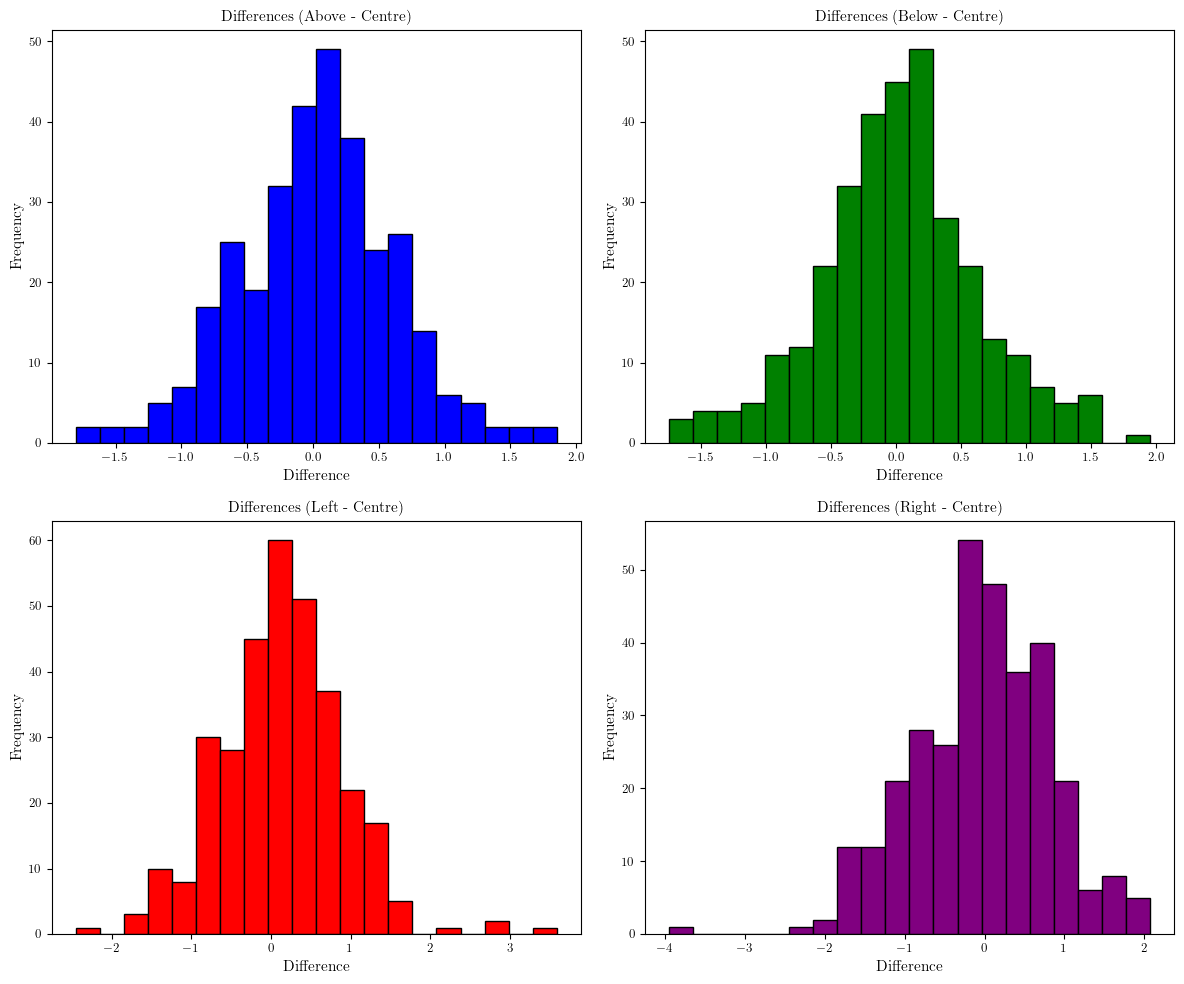

In [108]:
# Plot histograms for the different differences
plt.figure(figsize=(7, 5))

plt.subplot(2, 2, 1)
plt.hist(differences['above'], bins=20, color='blue', edgecolor='black')
plt.title('Differences (Above - Centre)')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(differences['below'], bins=20, color='green', edgecolor='black')
plt.title('Differences (Below - Centre)')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(differences['left'], bins=20, color='red', edgecolor='black')
plt.title('Differences (Left - Centre)')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(differences['right'], bins=20, color='purple', edgecolor='black')
plt.title('Differences (Right - Centre)')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [102]:
def unique_process_gap_folders_with_surrounding_pixels_random(base_folder, df, series_dataframe,radius,num_points, filterp=False, scalep=False):
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    for gap_folder in gap_folders:
        print(gap_folder)
        series_dataframe = unique_add_time_series_for_random_points_to_df(series_dataframe, gap_folder, df,radius=50,num_points=3, filterp=filterp, scalep=scalep)

    return series_dataframe


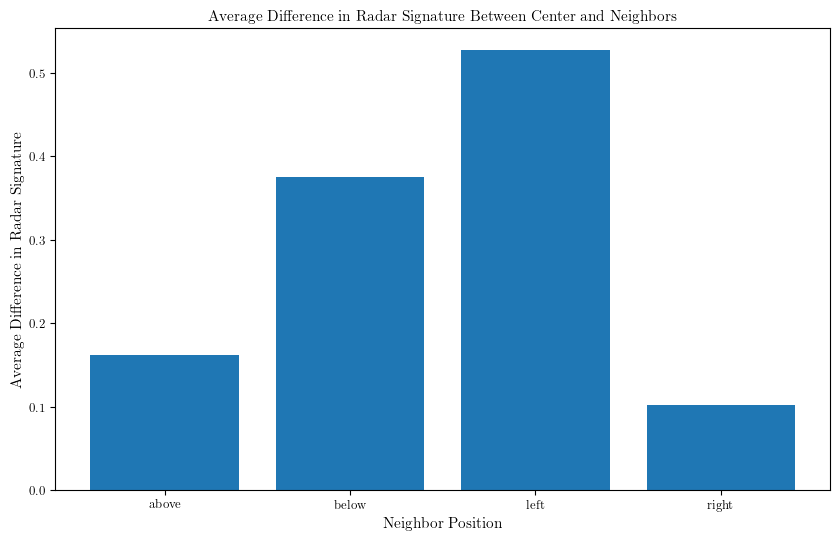

In [28]:

# Function to calculate the mean differences between center and neighbors
def calculate_mean_differences_corrected(df):
    mean_series = df.mean(axis=0)

    gap_numbers = [col.split('_')[0] for col in df.columns if col.endswith('centre')]
    unique_gap_numbers = sorted(set(gap_numbers))

    differences = {'above': [], 'below': [], 'left': [], 'right': []}

    for gap in unique_gap_numbers:
        centre_mean = mean_series[f'{gap}_centre']
        above_mean = mean_series[f'{gap}_above']
        below_mean = mean_series[f'{gap}_below']
        left_mean = mean_series[f'{gap}_left']
        right_mean = mean_series[f'{gap}_right']

        differences['above'].append(above_mean - centre_mean)
        differences['below'].append(below_mean - centre_mean)
        differences['left'].append(left_mean - centre_mean)
        differences['right'].append(right_mean - centre_mean)


    avg_differences = {key: np.mean(val) for key, val in differences.items()}
    return avg_differences

# Calculate the mean differences
avg_differences = calculate_mean_differences_corrected(df_series_2yr_gaps_with_neighbours)

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(avg_differences.keys(), avg_differences.values())
plt.xlabel('Neighbor Position')
plt.ylabel('Average Difference in Radar Signature')
plt.title('Average Difference in Radar Signature Between Center and Neighbors')
plt.show()


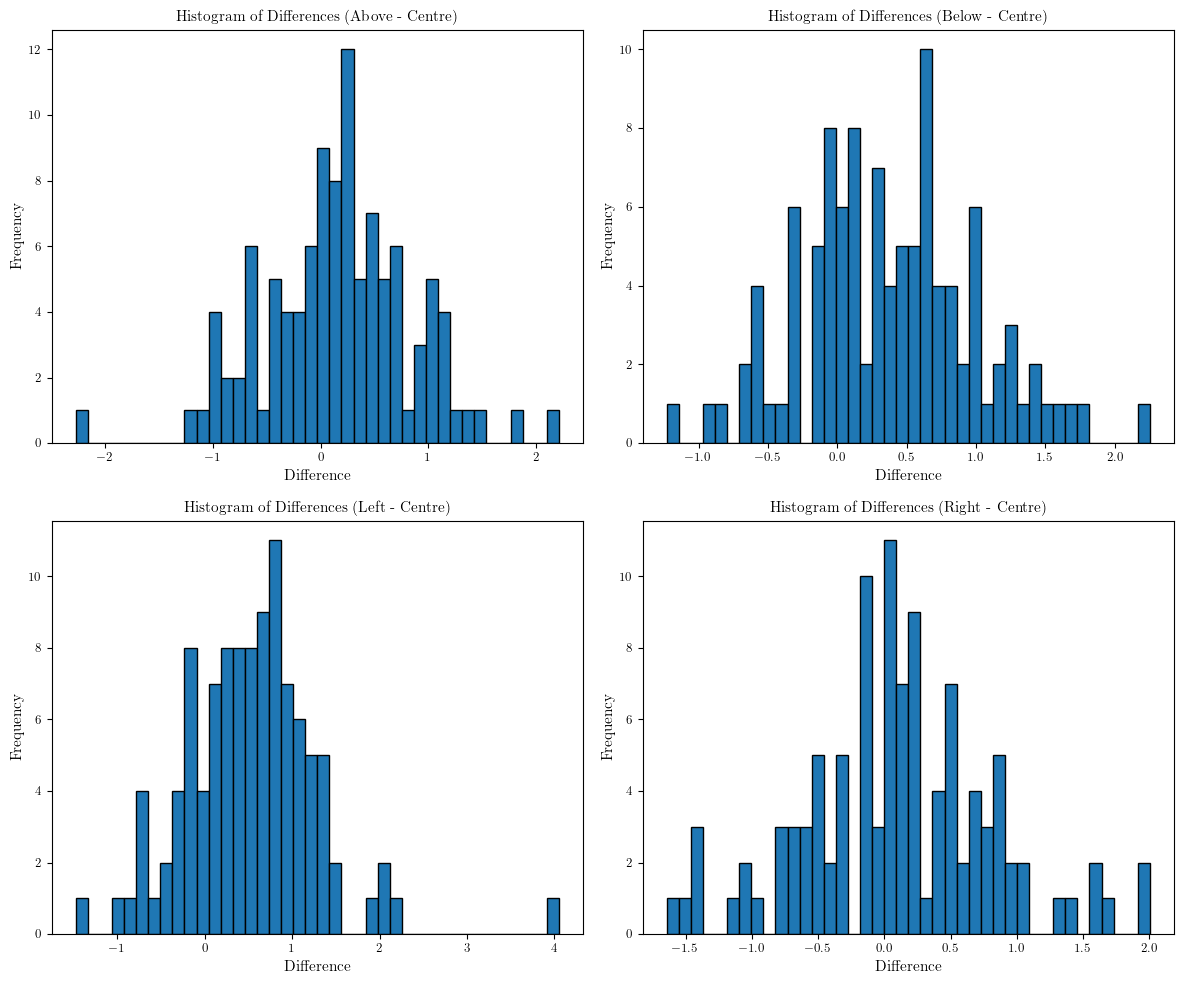

In [79]:

# Function to calculate the mean differences between center and neighbors
def calculate_differences_histograms(df):
    mean_series = df.mean(axis=0)

    gap_numbers = [col.split('_')[0] for col in df.columns if col.endswith('centre')]
    unique_gap_numbers = sorted(set(gap_numbers))

    differences = {'above': [], 'below': [], 'left': [], 'right': []}

    for gap in unique_gap_numbers:
        centre_mean = mean_series[f'{gap}_centre']
        above_mean = mean_series[f'{gap}_above']
        below_mean = mean_series[f'{gap}_below']
        left_mean = mean_series[f'{gap}_left']
        right_mean = mean_series[f'{gap}_right']

        differences['above'].append(above_mean - centre_mean)
        differences['below'].append(below_mean - centre_mean)
        differences['left'].append(left_mean - centre_mean)
        differences['right'].append(right_mean - centre_mean)

    return differences

# Calculate the differences
differences = calculate_differences_histograms(df_series_2yr_gaps_with_neighbours)

# Plot the histograms
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(differences['above'], bins=40, edgecolor='black')
plt.title('Histogram of Differences (Above - Centre)')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(differences['below'], bins=40, edgecolor='black')
plt.title('Histogram of Differences (Below - Centre)')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(differences['left'], bins=40, edgecolor='black')
plt.title('Histogram of Differences (Left - Centre)')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(differences['right'], bins=40, edgecolor='black')
plt.title('Histogram of Differences (Right - Centre)')
plt.xlabel('Difference')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## Create time series dataframes

In [22]:
## form generic dataframes ##

start_date = datetime(2017, 11, 11)
end_date = datetime.now()
date_range = pd.date_range(start_date, end_date, freq='D')

df_gen1 = pd.DataFrame(index=date_range)
df_gen2 = pd.DataFrame(index=date_range)

In [ ]:
df_series_alltime_gaps, df_series_alltime_random = process_gap_folders('downloaded_files', df, df_gen1, df_gen2, filterp=False, scalep=False)

In [24]:
df_series_2yr_gaps, df_series_2yr_random = process_gap_folders('downld_2yr_12dayinterval', df, df_gen1, df_gen2, filterp=False, scalep=False)

In [25]:
#df_series_2yr_gaps_filtered_kalman , df_series_2yr_random_filtered_kalman = process_gap_folders('downld_2yr_12dayinterval', df, df_gen1, df_gen2, filterp='kalman', scalep=False)
#df_series_2yr_gaps_filtered_savgol , df_series_2yr_random_filtered_savgol = process_gap_folders('downld_2yr_12dayinterval', df, df_gen1, df_gen2, filterp='savgol', scalep=False)

In [26]:
## Shorten the indefinete / alltime random dataframe so we can compare

def keep_first_two_years(df):
    df_copy = df.copy()
    for column in df_copy.columns:
        # Find the first non-NaN entry in the column
        first_valid_index = df_copy[column].first_valid_index()
        
        if first_valid_index is not None:
            # Calculate the date two years after the first non-NaN entry
            cutoff_date = first_valid_index + pd.DateOffset(years=2)
            
            # Set all entries after the cutoff date to NaN
            df_copy.loc[df_copy.index > cutoff_date, column] = pd.NA

    return df_copy

# Applying the function to the dataframe
#df_series_alltime_random_reduced = keep_first_two_years(df_series_alltime_random)

## Analyse slopes on time series

In [27]:
# Function to plot aggregate statistics for two dataframes on a single plot
def plot_aggregates(df1, df2, title1, title2, df3, df4, title3, title4):
    # Calculate the mean and standard deviation for the first dataframe set
    mean_series1 = df1.mean(axis=1, skipna=True).dropna()
    std_series1 = df1.std(axis=1, skipna=True).dropna()
    
    mean_series2 = df2.mean(axis=1, skipna=True).dropna()
    std_series2 = df2.std(axis=1, skipna=True).dropna()
    
    # Calculate the mean and standard deviation for the second dataframe set
    mean_series3 = df3.mean(axis=1, skipna=True).dropna()
    std_series3 = df3.std(axis=1, skipna=True).dropna()
    
    mean_series4 = df4.mean(axis=1, skipna=True).dropna()
    std_series4 = df4.std(axis=1, skipna=True).dropna()
    
    # Plot the results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.2, 5.5), sharex=True)
    
    # Plot for the first dataframe set
    ax1.plot(mean_series1, label=f'{title1} Mean', color='#FF0000')
    # ax1.fill_between(mean_series1.index, mean_series1 - std_series1, mean_series1 + std_series1, color='blue', alpha=0.2, label=f'{title1} Standard Deviation')
    
    ax1.plot(mean_series2, label=f'{title2} Mean', color='#0000FF')
    # ax1.fill_between(mean_series2.index, mean_series2 - std_series2, mean_series2 + std_series2, color='green', alpha=0.2, label=f'{title2} Standard Deviation')
    
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Pixel Values')
    ax1.text(1.02, 0.5, '(a)', transform=ax1.transAxes, verticalalignment='center', fontweight='bold')

    
    # Plot for the second dataframe set
    ax2.plot(mean_series3, label=f'{title3} Mean', color='#FF0000')
    # ax2.fill_between(mean_series3.index, mean_series3 - std_series3, mean_series3 + std_series3, color='blue', alpha=0.2, label=f'{title3} Standard Deviation')
    
    ax2.plot(mean_series4, label=f'{title4} Mean', color='#0000FF')
    # ax2.fill_between(mean_series4.index, mean_series4 - std_series4, mean_series4 + std_series4, color='green', alpha=0.2, label=f'{title4} Standard Deviation')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Pixel Values')
    ax2.legend()
    ax2.grid(True)
    ax2.text(1.02, 0.5, '(b)', transform=ax2.transAxes, verticalalignment='center', fontweight='bold')

    
    plt.tight_layout()


In [28]:
#plot_aggregates(df_series_alltime_gaps, df_series_alltime_random, 'Indefinite Gaps', 'Indefinite Random',df_series_2yr_gaps, df_series_alltime_random_reduced, '2 year Gaps', '2 year Random')
#plt.savefig('series_lineplot_double.pdf')

## Filtering and Time Series Length

### First Create Matrices to Hold Features
This will be used to compare how seperable certain features are and perform PCA

In [29]:
def extract_features(df, label):
    features = []
    for col in df.columns:
        series = df[col].dropna()  # Drop NaNs for feature calculation
        if not series.empty:
            mean_val = series.mean()
            var_val = series.var()
            skew_val = skew(series)
            max_val = series.max()
            min_val = series.min()
            range_val = max_val - min_val

            features.append({
                'name': col,
                'mean': mean_val,
                'variance': var_val,
                'skewness': skew_val,
                'max': max_val,
                'min': min_val,
                'range': range_val,
                'gap': label
            })

    return pd.DataFrame(features)

def create_feature_matrix(gap_df, random_df, area_df):
    # Make copies of the dataframes to avoid modifying the original ones
    gap_df = gap_df.copy()
    random_df = random_df.copy()
    area_df = area_df.copy()

    # Extract features for both dataframes
    gap_features = extract_features(gap_df, label=1)
    random_features = extract_features(random_df, label=0)

    # Add a zero-indexed row number to area_df
    area_df['row_index'] = area_df.index

    # Extract the numeric part of the 'name' column from gap_features
    gap_features['name_index'] = gap_features['name'].str.extract('(\d+)').astype(int)

    # Merge based on the row number
    gap_features = gap_features.merge(area_df[['row_index', 'area']], left_on='name_index', right_on='row_index', how='left')
    gap_features = gap_features.drop(columns=['row_index', 'name_index'])

    # Add area column to random_features with NaN values
    random_features['area'] = np.nan

    # Combine the features into a single DataFrame
    X_df = pd.concat([gap_features, random_features], ignore_index=True)

    return X_df


In order to compare with the same set of random points, we must extract random points with neighbours, and then remove the neighbours and keep the centre points. This will then be used to compare with the centre points of the spatial filters, once the filtering has been completed, and the neighbours have been used.

In [53]:
def rename_for_compare(dfx):

    df = dfx.copy()
    # Filter columns to keep only those with 'centre'
    centre_cols = [col for col in df.columns if 'centre' in col]
    df_centre_only = df[centre_cols]

    # Rename columns to remove '_centre' part
    new_col_names = [col.replace('_centre', '') for col in df_centre_only.columns]
    df_centre_only.columns = new_col_names

    return df_centre_only

# Assuming df_series_2yr_random_with_neighbours is your input DataFrame
df_series_2yr_random_for_filter_comparison = rename_for_compare(df_series_2yr_random_with_neighbours)

df_temporal_gaps = rename_for_compare(df_series_2yr_gaps_with_neighbours)

df_temporal_lee_gaps=df_series_2yr_gaps_with_neighbours.copy()
df_temporal_lee_random = df_series_2yr_random_with_neighbours.copy()

### Now Create Filter Time Series Dataframes

In [48]:
## ALL FILTERING FUNCTIONS

def dB_to_linear(db_array):
    """Convert dB to linear scale."""
    return 10 ** (db_array / 10)

def linear_to_dB(linear_array):
    """Convert linear scale to dB."""
    return 10 * np.log10(linear_array)

def frost_filter(data):
    """Apply Frost filter to a 2D array with time series in rows and 9 columns for neighbors."""
    filtered_data = np.zeros(data.shape[0])
    pad_size = 1
    padded_data = np.pad(data, ((pad_size, pad_size), (0, 0)), mode='edge')
    
    for t in range(data.shape[0]):
        local_window = padded_data[t:t + 3, :]
        local_mean = np.mean(local_window, axis=0)
        local_variance = np.var(local_window, axis=0)
        coefficients = np.exp(-np.abs(local_window - data[t, :]) / (2 * local_variance))
        weights = coefficients / np.sum(coefficients, axis=0)
        filtered_data[t] = np.sum(weights * local_window, axis=0)[0]
    
    return filtered_data


def lee_filter(data):
    """Apply Lee filter to a 2D array with time series in rows and 9 columns for neighbors."""
    filtered_data = np.zeros(data.shape[0])
    pad_size = 1
    padded_data = np.pad(data, ((pad_size, pad_size), (0, 0)), mode='edge')
    
    noise_variance = np.var(data)  # Estimate noise variance from the entire data

    for t in range(data.shape[0]):
        local_window = padded_data[t:t + 3, :]
        local_mean = np.mean(local_window, axis=0)
        local_variance = np.var(local_window, axis=0)
        k = local_variance / (local_variance + noise_variance)
        filtered_data[t] = local_mean[0] + k[0] * (data[t, 0] - local_mean[0])
    
    return filtered_data


def adaptive_wiener_filter(data):
    """Apply Adaptive Wiener filter to a 2D array with time series in rows and 9 columns for neighbors."""
    filtered_data = np.zeros(data.shape[0])
    pad_size = 1
    padded_data = np.pad(data, ((pad_size, pad_size), (0, 0)), mode='edge')

    for t in range(data.shape[0]):
        local_window = padded_data[t:t + 3, :]
        local_mean = np.mean(local_window, axis=0)
        local_variance = np.var(local_window, axis=0)
        noise_variance = np.var(data)
        k = local_variance / (local_variance + noise_variance)
        filtered_data[t] = local_mean[0] + k[0] * (data[t, 0] - local_mean[0])

    return filtered_data


def process_dataframe(df, labels,filter):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    # Initialize output DataFrame with the same index as df_gen1
    df_filtered = pd.DataFrame(index=df.index)
    
    for gap_id in range(1, 108):
        # Extract time series for 9 pixels around each gap
        cols = [f'gap{gap_id}_{label}' for label in labels]
        sub_df = df[cols]
        
        # Skip if all values are NaN
        if sub_df.isnull().all().all():
            continue
        
        # Convert from dB to linear scale
        sub_df_linear = dB_to_linear(sub_df)
        
        # Drop rows with NaNs
        sub_df_linear.dropna(inplace=True)
        
        if sub_df_linear.empty:
            continue
        
        if filter=='frost':
            filtered_linear = frost_filter(sub_df_linear.values)
        elif filter=='lee':
            filtered_linear = lee_filter(sub_df_linear.values)
        
        # Convert back to dB scale
        filtered_db = linear_to_dB(filtered_linear)
        
        # Add filtered data of the center pixel to the output DataFrame
        filtered_series = pd.Series(filtered_db, index=sub_df_linear.index)
        df_filtered[f'gap{gap_id}_centre'] = filtered_series
    
    return df_filtered


def process_random_dataframe(df, labels, filter):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    # Initialize output DataFrame with the same index as df_gen1
    df_filtered = pd.DataFrame(index=df.index)
    
    for gap_id in range(1, 108):
        for random_id in range(1, 4):
            # Extract time series for 9 pixels around each random point in each gap
            cols = [f'gap{gap_id}_random{random_id}_{label}' for label in labels]
            sub_df = df[cols]
            
            # Skip if all values are NaN
            if sub_df.isnull().all().all():
                continue
            
            # Convert from dB to linear scale
            sub_df_linear = dB_to_linear(sub_df)
            
            # Drop rows with NaNs
            sub_df_linear.dropna(inplace=True)
            
            if sub_df_linear.empty:
                continue
            
            if filter=='frost':
                filtered_linear = frost_filter(sub_df_linear.values)
            elif filter=='lee':
                filtered_linear = lee_filter(sub_df_linear.values)
            
            # Convert back to dB scale
            filtered_db = linear_to_dB(filtered_linear)
            
            # Add filtered data of the center pixel to the output DataFrame
            filtered_series = pd.Series(filtered_db, index=sub_df_linear.index)
            df_filtered[f'gap{gap_id}_random{random_id}_centre'] = filtered_series
    
    return df_filtered


def apply_median_temporal_filter(df, window_size=3):
    """Apply a median temporal filter to the time series in the dataframe."""
    filtered_df = pd.DataFrame(index=df.index)
    
    for col in df.columns:
        # Convert from dB to linear scale
        time_series = df[col].values
        
        # Drop NaNs and keep the index for restoring later
        non_nan_series = df[col].dropna()
        non_nan_index = non_nan_series.index
        non_nan_values = dB_to_linear(non_nan_series.values)
        
        # Apply the median filter
        filtered_non_nan_values = median_filter(non_nan_values, size=window_size)
        
        # Convert back to dB scale
        filtered_non_nan_db = linear_to_dB(filtered_non_nan_values)
        
        # Create a series to hold the filtered values, reintroducing NaNs where appropriate
        filtered_series = pd.Series(data=np.nan, index=df.index)
        filtered_series[non_nan_index] = filtered_non_nan_db
        
        # Store the filtered time series in the output DataFrame
        filtered_df[col] = filtered_series
    
    return filtered_df




In [49]:
### PROCESS FUNCTIONS WITH UPDATES FOR WIENER FILTER
### UNTESTED SO DONT DELETE PREVIOUS ONES YET


def process_dataframe(df, labels, filter_type):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    df_filtered = pd.DataFrame(index=df.index)
    
    for gap_id in range(1, 108):
        cols = [f'gap{gap_id}_{label}' for label in labels]
        sub_df = df[cols]
        
        if sub_df.isnull().all().all():
            continue
        
        sub_df_linear = dB_to_linear(sub_df)
        sub_df_linear.dropna(inplace=True)
        
        if sub_df_linear.empty:
            continue
        
        if filter_type == 'frost':
            filtered_linear = frost_filter(sub_df_linear.values)
        elif filter_type == 'lee':
            filtered_linear = lee_filter(sub_df_linear.values)
        elif filter_type == 'adaptive_wiener':
            filtered_linear = adaptive_wiener_filter(sub_df_linear.values)
        
        filtered_db = linear_to_dB(filtered_linear)
        filtered_series = pd.Series(filtered_db, index=sub_df_linear.index)
        df_filtered[f'gap{gap_id}_centre'] = filtered_series
    
    return df_filtered


def process_random_dataframe(df, labels, filter_type):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    df_filtered = pd.DataFrame(index=df.index)
    
    for gap_id in range(1, 108):
        for random_id in range(1, 4):
            cols = [f'gap{gap_id}_random{random_id}_{label}' for label in labels]
            sub_df = df[cols]
            
            if sub_df.isnull().all().all():
                continue
            
            sub_df_linear = dB_to_linear(sub_df)
            sub_df_linear.dropna(inplace=True)
            
            if sub_df_linear.empty:
                continue
            
            if filter_type == 'frost':
                filtered_linear = frost_filter(sub_df_linear.values)
            elif filter_type == 'lee':
                filtered_linear = lee_filter(sub_df_linear.values)
            elif filter_type == 'adaptive_wiener':
                filtered_linear = adaptive_wiener_filter(sub_df_linear.values)
            
            filtered_db = linear_to_dB(filtered_linear)
            filtered_series = pd.Series(filtered_db, index=sub_df_linear.index)
            df_filtered[f'gap{gap_id}_random{random_id}_centre'] = filtered_series
    
    return df_filtered

In [54]:
## CREATION OF FILTERED DATAFRAMES
'''
IN GENERAL:
start with dataframes with neighbours: df_series_2yr_gaps_with_neighbours, df_series_2yr_random_with_neighbours
then put them through the relevant filters.
Changes slightly for temporal filters since neighbours arent needed
'''

labels = ['centre', 'above', 'below', 'left', 'right', 'top_left', 'top_right', 'bottom_left', 'bottom_right']

df_frost_gaps = process_dataframe(df_series_2yr_gaps_with_neighbours, labels, 'frost')
df_frost_gaps = df_frost_gaps.reindex(df_gen1.index)

df_frost_random=process_random_dataframe(df_series_2yr_random_with_neighbours,labels, 'frost')
df_frost_random = df_frost_random.reindex(df_gen1.index)

df_lee_gaps = df_frost_gaps = process_dataframe(df_series_2yr_gaps_with_neighbours, labels,'lee')
df_lee_gaps = df_lee_gaps.reindex(df_gen1.index)

df_lee_random=process_random_dataframe(df_series_2yr_random_with_neighbours,labels, 'lee')
df_lee_random = df_lee_random.reindex(df_gen1.index)

df_temporal_gaps = rename_for_compare(df_series_2yr_gaps_with_neighbours)
df_temporal_gaps = apply_median_temporal_filter(df_temporal_gaps)
df_temporal_random = apply_median_temporal_filter(df_series_2yr_random_for_filter_comparison)

df_temporal_lee_gaps = apply_median_temporal_filter(df_temporal_lee_gaps)
df_temporal_lee_gaps = process_dataframe(df_temporal_lee_gaps, labels, 'lee')
df_temporal_lee_gaps = df_temporal_lee_gaps.reindex(df_gen1.index)

df_temporal_lee_random=apply_median_temporal_filter(df_temporal_lee_random)
df_temporal_lee_random=process_random_dataframe(df_temporal_lee_random,labels,'lee')
df_temporal_lee_random=df_temporal_lee_random.reindex(df_gen1.index)

df_lee_temporal_gaps=apply_median_temporal_filter(df_lee_gaps.copy())
df_lee_temporal_random=apply_median_temporal_filter(df_lee_random.copy())

df_wiener_gaps=process_dataframe(df_series_2yr_gaps_with_neighbours,labels,'adaptive_wiener').reindex(df_gen1.index)
df_wiener_random=process_random_dataframe(df_series_2yr_random_with_neighbours,labels,'adaptive_wiener').reindex(df_gen1.index)


In [58]:
## NOW CREATE FEATURE DATAFRAMES AFTER FILTERED TIME SERIES HAVE BEEN CREATED

#X_df_alltime = create_feature_matrix(df_series_alltime_gaps, df_series_alltime_random, df)

X_df_2yr = create_feature_matrix(df_series_2yr_gaps, df_series_2yr_random_for_filter_comparison, df)

#X_df_2yr_reduced = create_feature_matrix(df_series_2yr_gaps,df_series_alltime_random_reduced, df)

X_df_2yr_frost = create_feature_matrix(df_frost_gaps, df_frost_random,df)

X_df_2yr_lee = create_feature_matrix(df_lee_gaps, df_lee_random,df)

X_df_2yr_lee_temporal = create_feature_matrix(df_temporal_lee_gaps, df_temporal_lee_random,df)

X_df_2yr_temporal_lee = create_feature_matrix(df_lee_temporal_gaps,df_lee_temporal_random,df)

X_df_2yr_adaptive_wiener = create_feature_matrix(df_wiener_gaps,df_wiener_random,df)

In [35]:
def mean_var_axis1(df):

    '''
    calculate mean and variance for each date
    effectively the 'average' time series
    '''

    mean=df.mean(axis=1)
    variance=df.var(axis=1)

    return(mean,variance)


def mean_var_axis0(df):
    
    '''
    calculates mean and variance for each time series
    acts down columns
    '''

    mean=df.mean(axis=0)
    variance=df.var(axis=0)

    return(mean,variance)


def aggregate_and_ensemble_vals(df):
    
    ### calculate 'average' time series
    m1,v1=mean_var_axis0(df)
    ensemble_mean=np.mean(m1)
    ensemble_var=np.var(m1)

    ### calculate mean of each time series
    m2,v2=mean_var_axis1(df)
    aggregate_mean=np.mean(m2)
    aggregate_var=np.var(m2)

    return((ensemble_mean,ensemble_var),(aggregate_mean,aggregate_var))

In [64]:
df_series_2yr_random1 = pd.DataFrame()
df_series_2yr_random2 = pd.DataFrame()
df_series_2yr_random3 = pd.DataFrame()

#df_series_alltime_random1 = pd.DataFrame()
#df_series_alltime_random2 = pd.DataFrame()
#df_series_alltime_random3 = pd.DataFrame()

df_series_2yr_random1_frost = pd.DataFrame()
df_series_2yr_random2_frost = pd.DataFrame()
df_series_2yr_random3_frost = pd.DataFrame()

df_series_2yr_random1_lee = pd.DataFrame()
df_series_2yr_random2_lee = pd.DataFrame()
df_series_2yr_random3_lee = pd.DataFrame()

df_series_2yr_random1_temporal = pd.DataFrame()
df_series_2yr_random2_temporal = pd.DataFrame()
df_series_2yr_random3_temporal = pd.DataFrame()

df_series_2yr_random1_temporal_lee = pd.DataFrame()
df_series_2yr_random2_temporal_lee = pd.DataFrame()
df_series_2yr_random3_temporal_lee = pd.DataFrame()

df_series_2yr_random1_lee_temporal = pd.DataFrame()
df_series_2yr_random2_lee_temporal = pd.DataFrame()
df_series_2yr_random3_lee_temporal = pd.DataFrame()

df_series_2yr_random1_wiener = pd.DataFrame()
df_series_2yr_random2_wiener = pd.DataFrame()
df_series_2yr_random3_wiener = pd.DataFrame()


# Separate columns based on their suffix (random1, random2, random3)
for col in df_series_2yr_random_for_filter_comparison.columns:
    if col.endswith('_random1'):
        df_series_2yr_random1[col] = df_series_2yr_random_for_filter_comparison[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2'):
        df_series_2yr_random2[col] = df_series_2yr_random_for_filter_comparison[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3'):
        df_series_2yr_random3[col] = df_series_2yr_random_for_filter_comparison[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

#for col in df_series_alltime_random.columns:
#    if col.endswith('_random1'):
#        df_series_alltime_random1[col] = df_series_alltime_random[col]
#        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
#    elif col.endswith('_random2'):
#        df_series_alltime_random2[col] = df_series_alltime_random[col]
#        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
#    elif col.endswith('_random3'):
#        df_series_alltime_random3[col] = df_series_alltime_random[col]
#        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Separate columns based on their suffix (random1, random2, random3)
for col in df_frost_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_frost[col] = df_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_frost[col] = df_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_frost[col] = df_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Separate columns based on their suffix (random1, random2, random3)
for col in df_lee_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_lee[col] = df_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_lee[col] = df_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_lee[col] = df_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_temporal_random.columns:
    if col.endswith('_random1'):
        df_series_2yr_random1_temporal[col] = df_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2'):
        df_series_2yr_random2_temporal[col] = df_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3'):
        df_series_2yr_random3_temporal[col] = df_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


for col in df_temporal_lee_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_temporal_lee[col] = df_temporal_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_temporal_lee[col] = df_temporal_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_temporal_lee[col] = df_temporal_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


for col in df_lee_temporal_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_lee_temporal[col] = df_lee_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_lee_temporal[col] = df_lee_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_lee_temporal[col] = df_lee_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


for col in df_wiener_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_wiener[col] = df_wiener_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_wiener[col] = df_wiener_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_wiener[col] = df_wiener_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


In [67]:
#alltime_dfs = [df_series_alltime_gaps, [df_series_alltime_random1, df_series_alltime_random2, df_series_alltime_random3]]
_2yr_dfs = [df_series_2yr_gaps, [df_series_2yr_random1,df_series_2yr_random2,df_series_2yr_random3]]

_2yr_dfs_frost = [df_frost_gaps, [df_series_2yr_random1_frost,df_series_2yr_random2_frost,df_series_2yr_random3_frost]]
_2yr_dfs_lee = [df_lee_gaps, [df_series_2yr_random1_lee,df_series_2yr_random2_lee,df_series_2yr_random3_lee]]
_2yr_dfs_temporal = [df_temporal_gaps, [df_series_2yr_random1_temporal,df_series_2yr_random2_temporal,df_series_2yr_random3_temporal]]
_2yr_dfs_temporal_lee = [df_temporal_lee_gaps, [df_series_2yr_random1_temporal_lee,df_series_2yr_random2_temporal_lee,df_series_2yr_random3_temporal_lee]]
_2yr_dfs_lee_temporal = [df_lee_temporal_gaps, [df_series_2yr_random1_lee_temporal,df_series_2yr_random2_lee_temporal,df_series_2yr_random3_lee_temporal]]
_2yr_dfs_wiener = [df_wiener_gaps, [df_series_2yr_random1_wiener,df_series_2yr_random2_wiener,df_series_2yr_random3_wiener]]

In [40]:
def extract_variances(dfs):
    variances = []
    for df in dfs:
        _, variance = mean_var_axis0(df)
        variances.append(variance)
    return variances

def plot_boxplots(alltime_dfs, _2yr_dfs):
    # Extract variances for each set of dataframes
    variances_alltime = extract_variances([alltime_dfs[0]] + alltime_dfs[1])
    variances_2yr = extract_variances([_2yr_dfs[0]] + _2yr_dfs[1])
    
    # Combine all variances for plotting
    data_alltime = variances_alltime
    data_2yr = variances_2yr

    # Labels for the boxplots
    labels_alltime = ['Gap', 'Random 1', 'Random 2', 'Random 3']
    labels_2yr = ['Gap', 'Random 1', 'Random 2', 'Random 3']

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

    # Boxplot properties
    boxprops = dict(facecolor='blue', color='black')
    medianprops = dict(color='red', linewidth=2)
    whiskerprops = dict(color='black', linewidth=2)
    capprops = dict(color='black', linewidth=2)
    flierprops = dict(marker='o', color='blue', alpha=0.5)
    
    # Boxplot for Alltime dataframes
    bp_alltime = axs[0].boxplot(data_alltime, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, showmeans=True)
    axs[0].set_xticklabels(labels_alltime, rotation=45)
    axs[0].set_ylabel('Variance')
    axs[0].set_title('(a)')
    axs[0].grid(True)

    # Boxplot for 2-Year dataframes
    bp_2yr = axs[1].boxplot(data_2yr, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, showmeans=True)
    axs[1].set_xticklabels(labels_2yr, rotation=45)
    axs[1].set_title('(b)')
    axs[1].grid(True)

    # Customize the mean points
    for mean in bp_alltime['means']:
        mean.set(marker='o', color='red', markersize=7)
    for mean in bp_2yr['means']:
        mean.set(marker='o', color='red', markersize=7)

    plt.tight_layout()

#plot_boxplots(alltime_dfs, _2yr_dfs)
#plt.savefig('boxplot_variance.pdf')

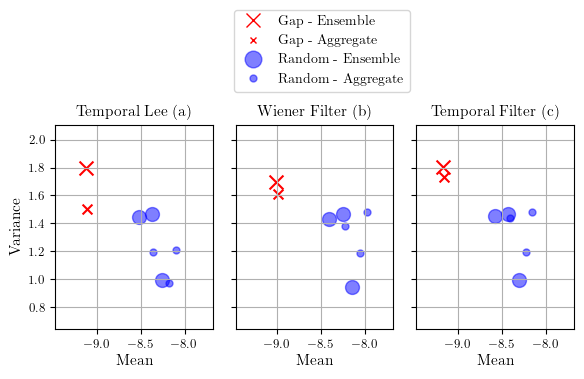

In [68]:
def plot_side_by_side(dfs1, dfs2, dfs3, labels1, labels2, labels3):
    fig, axs = plt.subplots(1, 3, figsize=(6, 3), sharex=True, sharey=True)

    # Initialize lists to hold all the scatter points for x and y
    all_x = []
    all_y = []

    def plot_scatter(ax, gap_df, random_dfs, color_gap, color_random):
        (ensemble_mean, ensemble_var), (aggregate_mean, aggregate_var) = aggregate_and_ensemble_vals(gap_df)
        all_x.extend([ensemble_mean, aggregate_mean])
        all_y.extend([ensemble_var, aggregate_var])
        ax.scatter(ensemble_mean, ensemble_var, color=color_gap, marker='x', s=100, label='Gap - Ensemble')
        ax.scatter(aggregate_mean, aggregate_var, color=color_gap, marker='x', s=50, label='Gap - Aggregate')
        for df in random_dfs:
            (ensemble_mean, ensemble_var), (aggregate_mean, aggregate_var) = aggregate_and_ensemble_vals(df)
            all_x.extend([ensemble_mean, aggregate_mean])
            all_y.extend([ensemble_var, aggregate_var])
            ax.scatter(ensemble_mean, ensemble_var, color=color_random, marker='o', s=100, label='Random - Ensemble', alpha=0.5)
            ax.scatter(aggregate_mean, aggregate_var, color=color_random, marker='o', s=25, label='Random - Aggregate', alpha=0.5)

    # Plot for the first set of dataframes (Alltime)
    gap_df1, random_dfs1 = dfs1
    plot_scatter(axs[0], gap_df1, random_dfs1, 'red', 'blue')
    axs[0].set_title(labels1)
    axs[0].set_xlabel('Mean')
    axs[0].set_ylabel('Variance')
    axs[0].grid()

    # Plot for the second set of dataframes (2-Year)
    gap_df2, random_dfs2 = dfs2
    plot_scatter(axs[1], gap_df2, random_dfs2, 'red', 'blue')
    axs[1].set_title(labels2)
    axs[1].set_xlabel('Mean')
    axs[1].grid()

    # Plot for the third set of dataframes (Third set)
    gap_df3, random_dfs3 = dfs3
    plot_scatter(axs[2], gap_df3, random_dfs3, 'red', 'blue')
    axs[2].set_title(labels3)
    axs[2].set_xlabel('Mean')
    axs[2].grid()

    # Compute the min and max for x and y with a 0.2 border
    x_min, x_max = min(all_x) - 0.3, max(all_x) + 0.3
    y_min, y_max = min(all_y) - 0.3, max(all_y) + 0.3

    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    # Custom legend
    handles = [
        plt.Line2D([0], [0], marker='x', color='w', label='Gap - Ensemble', markerfacecolor='none', markeredgecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='x', color='w', label='Gap - Aggregate', markerfacecolor='none', markeredgecolor='red', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Random - Ensemble', markerfacecolor='blue', markeredgecolor='blue', markersize=12, alpha=0.5),
        plt.Line2D([0], [0], marker='o', color='w', label='Random - Aggregate', markerfacecolor='blue', markeredgecolor='blue', markersize=5, alpha=0.5)
    ]
    fig.legend(handles=handles, loc='upper center', ncol=1, bbox_to_anchor=(0.55, 1.28))

    plt.tight_layout()

# Plotting the scatter plots
labels_alltime = 'Temporal Lee (a)'
labels_2yr = 'Wiener Filter (b)'
labels_3rd = 'Temporal Filter (c)'
plot_side_by_side(_2yr_dfs_temporal_lee, _2yr_dfs_wiener, _2yr_dfs_temporal, labels_alltime, labels_2yr, labels_3rd)
plt.savefig('filter_3_comparison.pdf')
plt.show()

In [74]:
## REMOVE AREA COLUMN FROM FEATURE DATAFRAMES SO WE CAN PLOT
# only area is removed since its numerical, but areas are only present for gap datapoints, not random ones

X_df_2yr_clean=X_df_2yr.drop(columns=['area'],axis=1)
X_df_2yr_frost_clean=X_df_2yr_frost.drop(columns=['area'],axis=1)
X_df_2yr_lee_clean = X_df_2yr_lee.drop(columns=['area'],axis=1)
X_df_2yr_lee_temporal_clean = X_df_2yr_lee_temporal.drop(columns=['area'],axis=1)
X_df_2yr_temporal_lee_clean=X_df_2yr_temporal_lee.drop(columns=['area'],axis=1)
X_df_2yr_adaptive_wiener_clean=X_df_2yr_adaptive_wiener.drop(columns=['area'],axis=1)

In [ ]:
def plot_scatter(X_df):
    # Create a scatter plot
    plt.figure(figsize=(6,4))
    
    # Plot the gap points
    gap_points = X_df[X_df['gap'] == 1]
    plt.scatter(gap_points['mean'], gap_points['variance'], color='red', marker='x', label='Gap')
    
    # Plot the non-gap points
    non_gap_points = X_df[X_df['gap'] == 0]
    plt.scatter(non_gap_points['mean'], non_gap_points['variance'], color='blue', marker='o', label='Non-Gap')
    
    # Add labels and legend
    plt.xlabel('Mean')
    plt.ylabel('Variance')
    plt.title('Scatter Plot of Mean vs Variance')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_scatter(X_df_alltime)

In [ ]:
X_df_2yr

c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


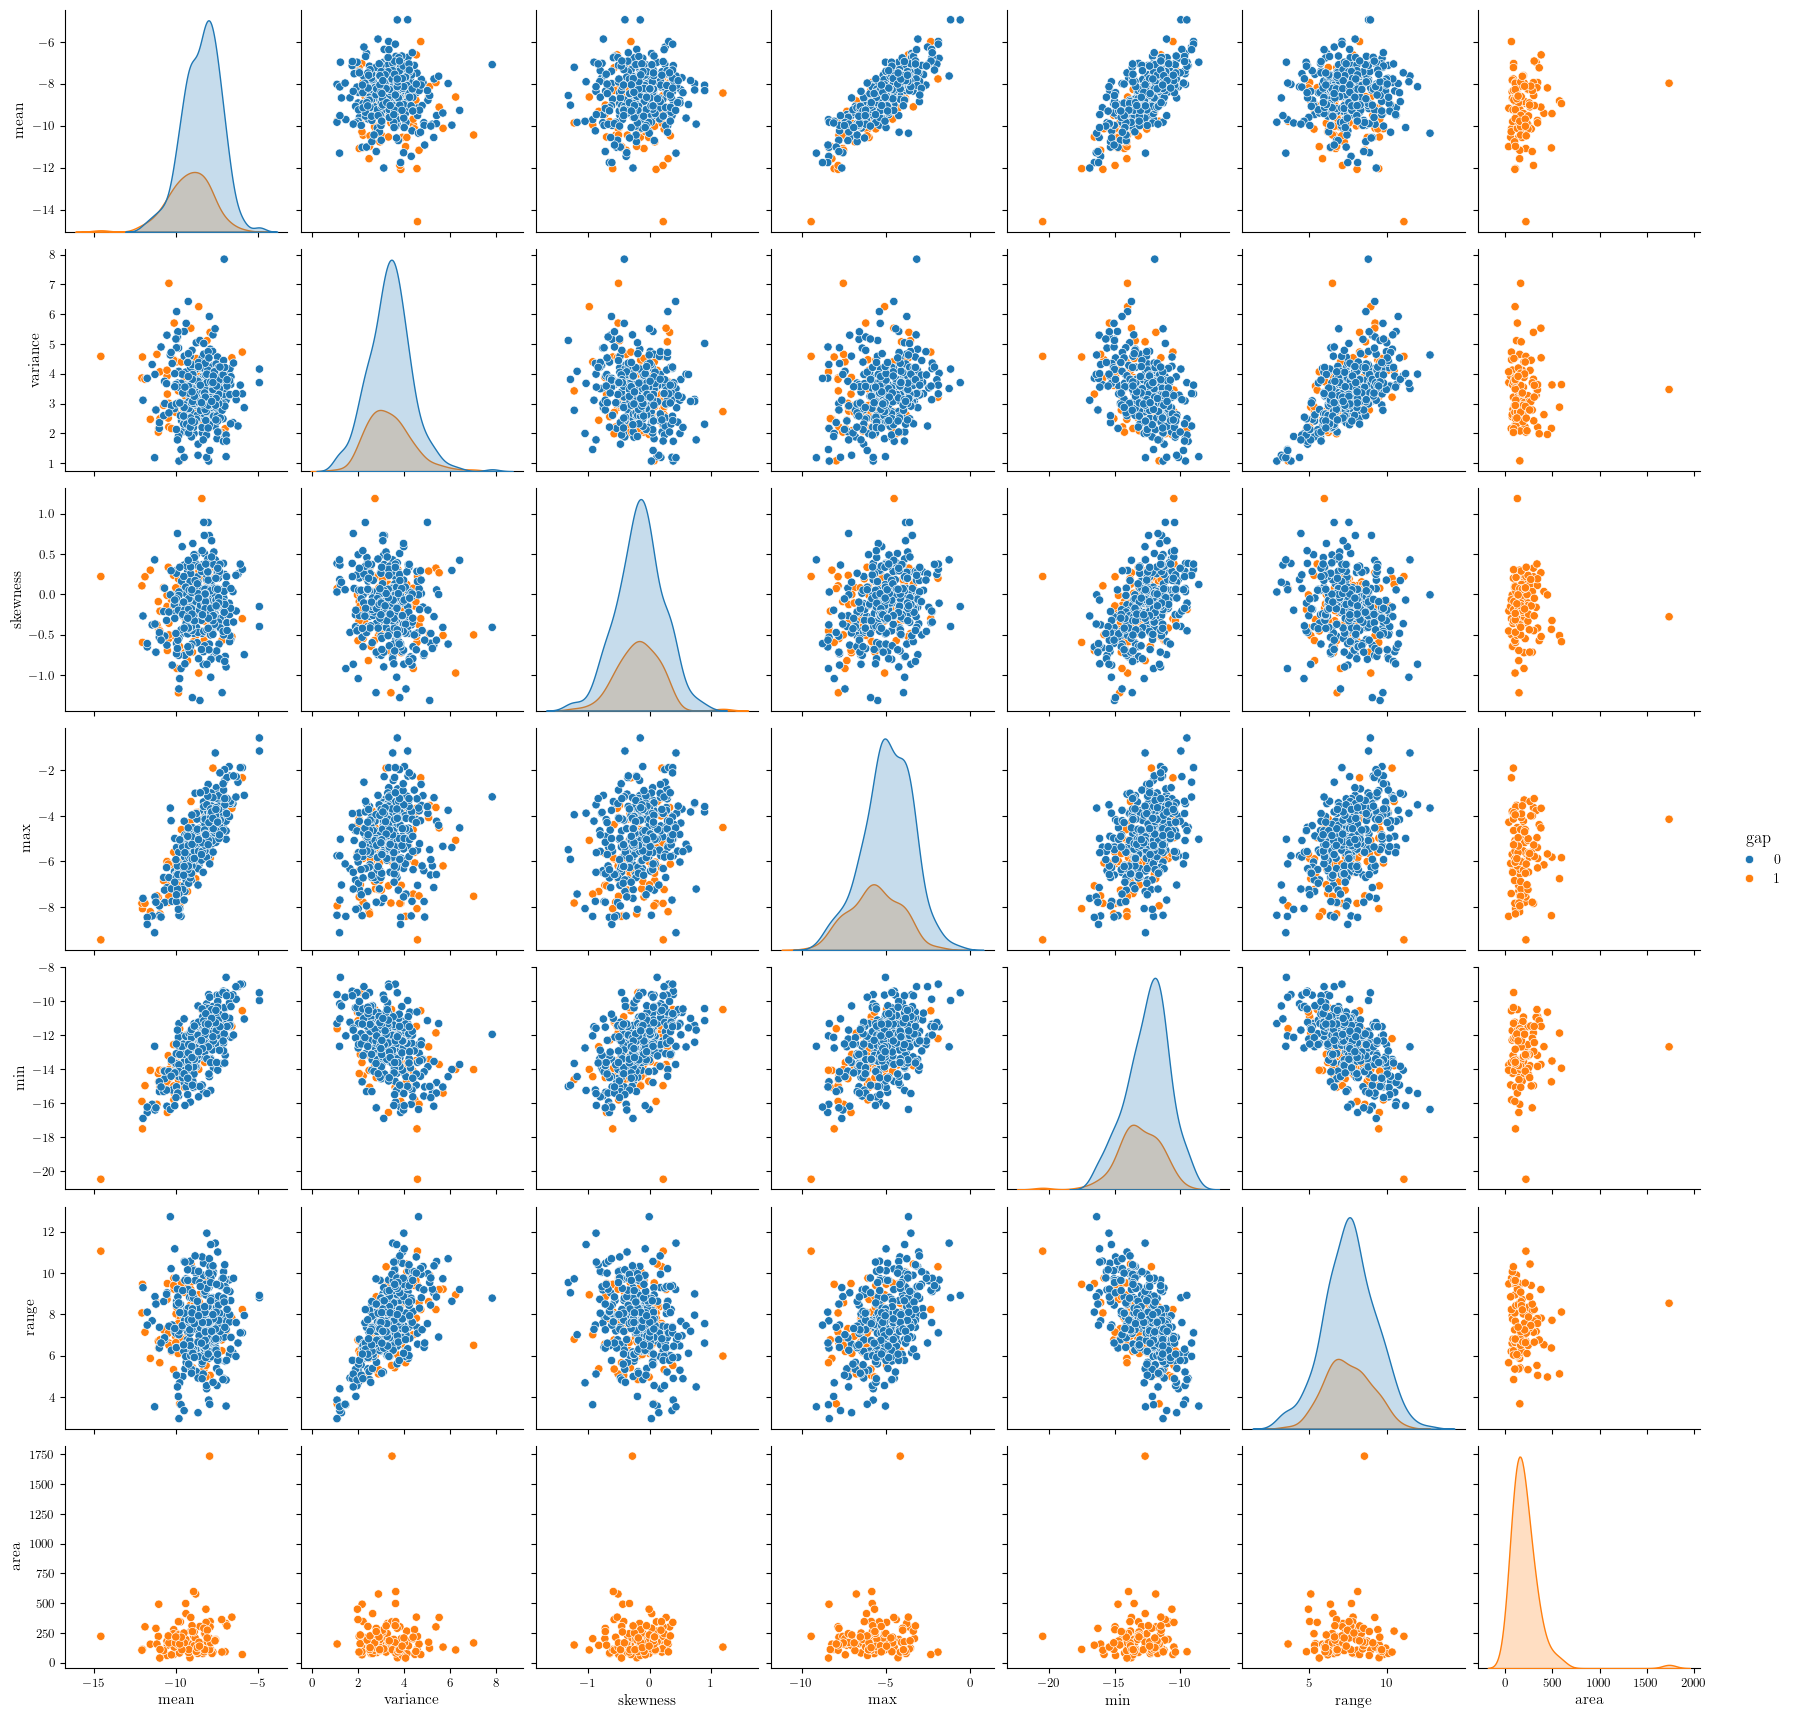

In [43]:
sns.pairplot(X_df_2yr,hue='gap')

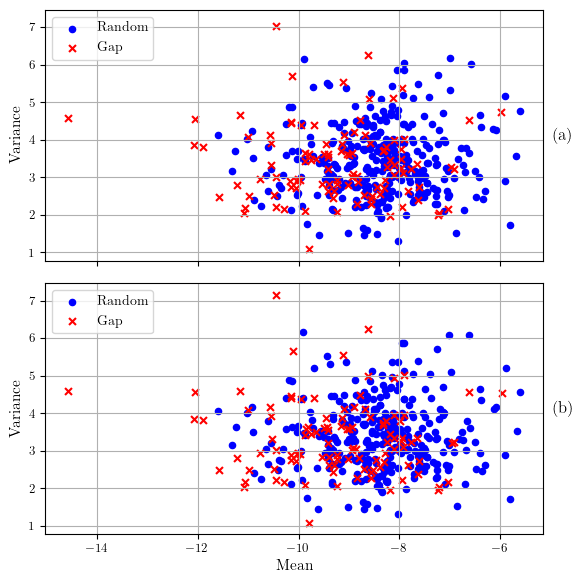

In [148]:
def plot_top_to_bottom_scatter(X_df1, X_df2, title1, title2):
    # Create a figure with two subplots, one on top of the other
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True,sharey=True)
    
    # Plot for the first dataframe
    gap_points1 = X_df1[X_df1['gap'] == 1]
    non_gap_points1 = X_df1[X_df1['gap'] == 0]
    
    ax1.scatter(non_gap_points1['mean'], non_gap_points1['variance'], color='blue', marker='o', label='Random',s=20)
    ax1.scatter(gap_points1['mean'], gap_points1['variance'], color='red', marker='x', label='Gap',s=25)
    ax1.set_ylabel('Variance')
    ax1.legend(loc = 'upper left')
    ax1.grid(True)
    ax1.text(1.02, 0.5, '(a)', transform=ax1.transAxes, verticalalignment='center', fontweight='bold')


    # Plot for the second dataframe
    gap_points2 = X_df2[X_df2['gap'] == 1]
    non_gap_points2 = X_df2[X_df2['gap'] == 0]

    ax2.scatter(non_gap_points2['mean'], non_gap_points2['variance'], color='blue', marker='o', label='Random',s=20)
    ax2.scatter(gap_points2['mean'], gap_points2['variance'], color='red', marker='x', label='Gap',s=25)
    ax2.set_xlabel('Mean')
    ax2.set_ylabel('Variance')
    ax2.legend(loc = 'upper left')
    ax2.grid(True)
    ax2.text(1.02, 0.5, '(b)', transform=ax2.transAxes, verticalalignment='center', fontweight='bold')

    
    plt.tight_layout()

# Example usage
plot_top_to_bottom_scatter(X_df_2yr, X_df_2yr_frost, 'All Time Data', '2 Year Data')
plt.savefig('allscatter_double.pdf')

In [150]:
X_df_2yr_lee_clean=X_df_2yr_lee.drop(columns=['area'],axis=1)

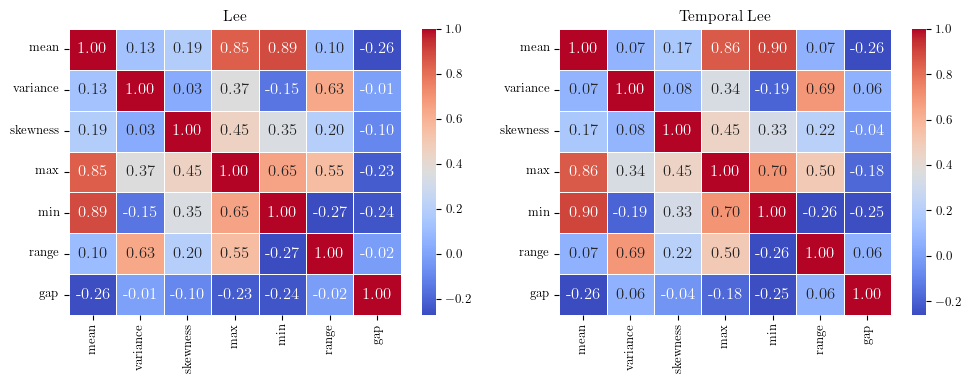

In [75]:
numeric_features_1 = X_df_2yr_lee_clean.drop(columns=['name'], errors='ignore')
correlation_matrix_1 = numeric_features_1.corr()

numeric_features_2 = X_df_2yr_temporal_lee_clean.drop(columns=['name'], errors='ignore')
correlation_matrix_2 = numeric_features_2.corr()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix_1, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Lee')

plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix_2, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5)
plt.title('Temporal Lee')
plt.tight_layout()
plt.show()

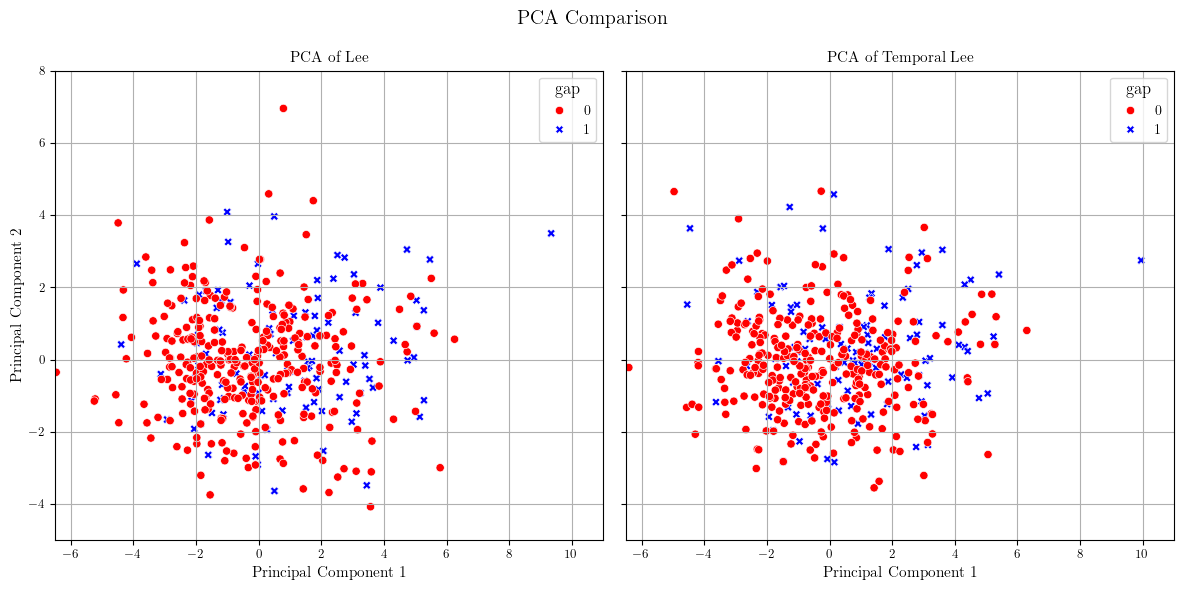

In [76]:

def perform_pca_and_plot_combined(X_df1, title1, X_df2, title2):
    # Define a helper function to perform PCA
    def perform_pca(X_df):
        features = X_df.drop(columns=['name', 'gap', 'area'], errors='ignore')
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(features.fillna(0))  # Fill NaN with 0 for PCA
        pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
        pca_df['gap'] = X_df['gap']
        return pca_df

    # Perform PCA on both datasets
    pca_df1 = perform_pca(X_df1)
    pca_df2 = perform_pca(X_df2)

    # Plot the PCA results side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df1,
                    palette={0: 'red', 1: 'blue'}, style='gap', markers={1: 'X', 0: 'o'}, ax=axes[0])
    axes[0].set_title(f'PCA of {title1}')
    axes[0].set_xlim(-6.5, 11)
    axes[0].set_ylim(-5, 8)
    axes[0].grid(True)

    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df2,
                    palette={0: 'red', 1: 'blue'}, style='gap', markers={1: 'X', 0: 'o'}, ax=axes[1])
    axes[1].set_title(f'PCA of {title2}')
    axes[1].set_xlim(-6.5, 11)
    axes[1].set_ylim(-5, 8)
    axes[1].grid(True)

    plt.suptitle('PCA Comparison')
    plt.tight_layout()
    plt.show()

# Example usage
perform_pca_and_plot_combined(X_df_2yr_lee_clean, 'Lee', X_df_2yr_temporal_lee_clean, 'Temporal Lee')


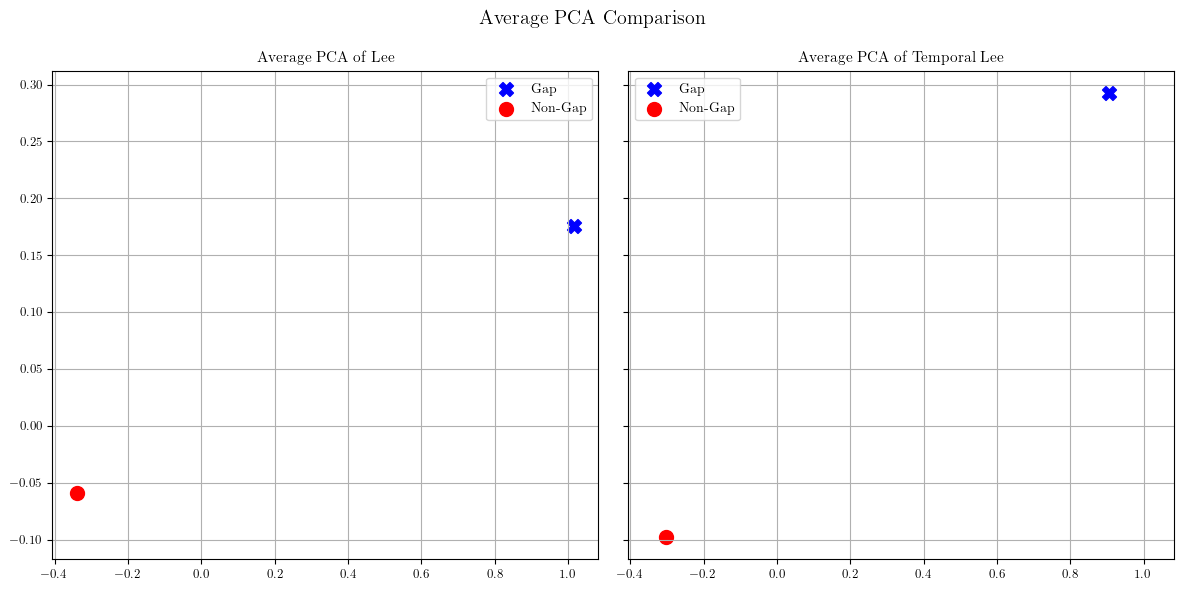

In [78]:
def perform_pca_and_plot_averages(X_df1, title1, X_df2, title2):
    # Define a helper function to perform PCA
    def perform_pca(X_df):
        features = X_df.drop(columns=['name', 'gap', 'area'], errors='ignore')
        pca = PCA(n_components=2)
        principal_components = pca.fit_transform(features.fillna(0))  # Fill NaN with 0 for PCA
        pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
        pca_df['gap'] = X_df['gap']
        return pca_df

    # Perform PCA on both datasets
    pca_df1 = perform_pca(X_df1)
    pca_df2 = perform_pca(X_df2)

    # Calculate average principal components for gaps and non-gaps
    avg_pca1_gap = pca_df1[pca_df1['gap'] == 1].mean()
    avg_pca1_nongap = pca_df1[pca_df1['gap'] == 0].mean()
    avg_pca2_gap = pca_df2[pca_df2['gap'] == 1].mean()
    avg_pca2_nongap = pca_df2[pca_df2['gap'] == 0].mean()

    # Plot the average principal components
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

    axes[0].scatter(avg_pca1_gap['Principal Component 1'], avg_pca1_gap['Principal Component 2'], color='blue', marker='X', s=100, label='Gap')
    axes[0].scatter(avg_pca1_nongap['Principal Component 1'], avg_pca1_nongap['Principal Component 2'], color='red', marker='o', s=100, label='Non-Gap')
    axes[0].set_title(f'Average PCA of {title1}')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].scatter(avg_pca2_gap['Principal Component 1'], avg_pca2_gap['Principal Component 2'], color='blue', marker='X', s=100, label='Gap')
    axes[1].scatter(avg_pca2_nongap['Principal Component 1'], avg_pca2_nongap['Principal Component 2'], color='red', marker='o', s=100, label='Non-Gap')
    axes[1].set_title(f'Average PCA of {title2}')
    axes[1].grid(True)
    axes[1].legend()

    plt.suptitle('Average PCA Comparison')
    plt.tight_layout()
    plt.show()

# Example usage

perform_pca_and_plot_averages(X_df_2yr_lee_clean, 'Lee', X_df_2yr_temporal_lee_clean, 'Temporal Lee')

### Other Metrics

In [24]:
def calculate_mean_variance(time_series):
    """
    Calculate the mean and variance of a given time series.

    Parameters:
    time_series (list): The input time series data.

    Returns:
    tuple: A tuple containing the mean and variance of the time series.
    """
    n = len(time_series)
    mean = sum(time_series) / n
    variance = sum((x - mean) ** 2 for x in time_series) / (n - 1)
    
    return mean, variance

# Example usage:
time_series_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mean, variance = calculate_mean_variance(time_series_data)

In [31]:
X_df_prime=X_df.sort_values(by='area',ascending=False).iloc[1:]

In [37]:
below_100 = X_df[X_df['area'] < 39].shape[0]

# Count the number of entries with area 100 and above
above_100 = X_df[X_df['area'] >= 100].shape[0]

below_100, above_100

(1, 90)

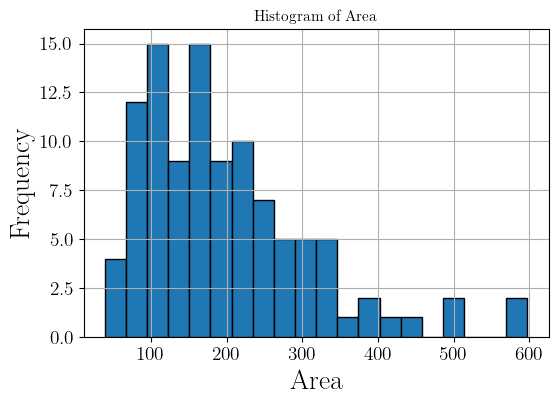

In [32]:
plt.figure(figsize=(6, 4))
plt.hist(X_df_prime['area'], bins=20, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Area')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

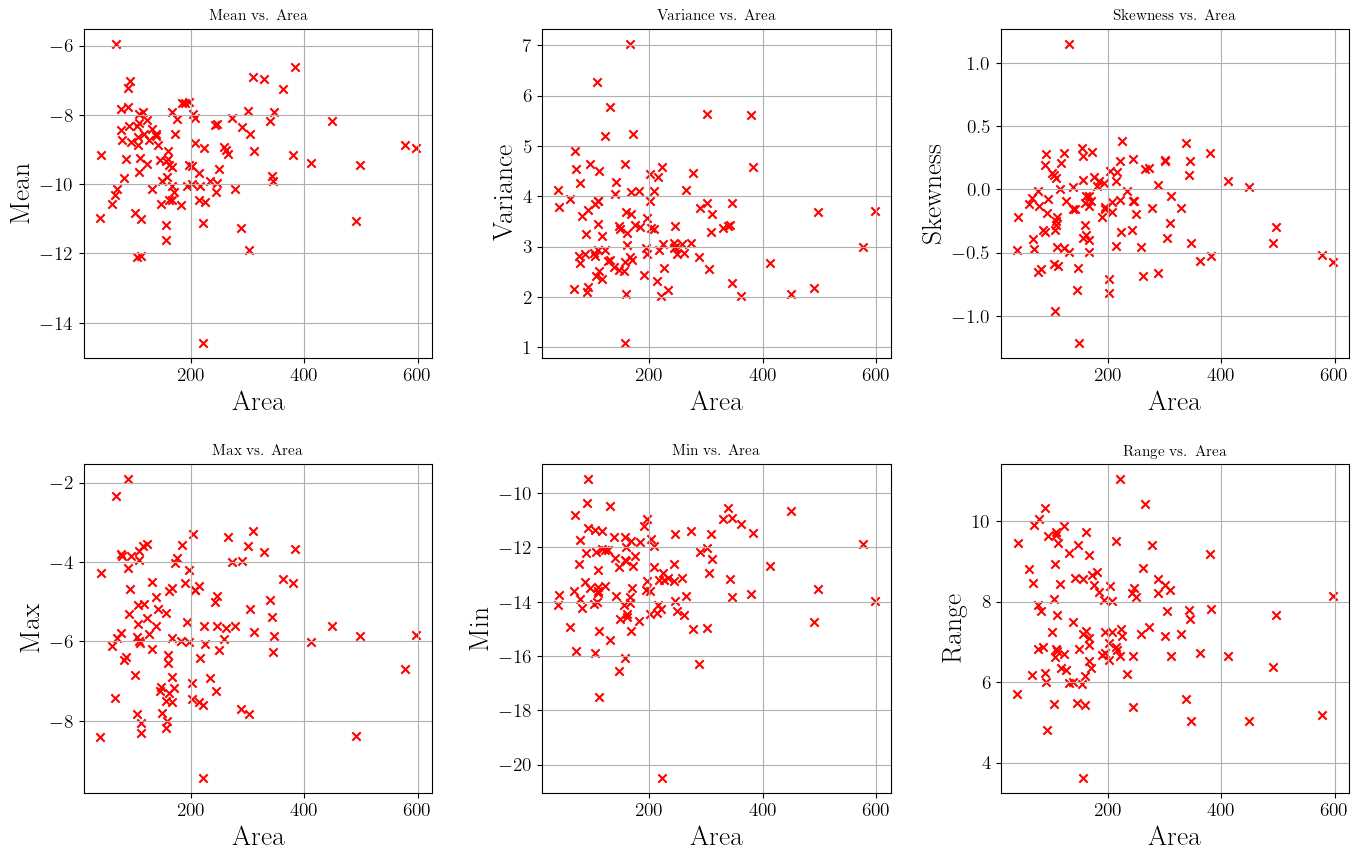

In [71]:
# Create subplots for each variable against area
fig, axs = plt.subplots(2, 3, figsize=(14, 9))

# List of variables to plot
variables = ['mean', 'variance', 'skewness', 'max', 'min', 'range']

gap_points = X_df[X_df['gap'] == 1]
random_points = X_df[X_df['gap'] == 0]

# Flatten the axes array for easy iteration
axs = axs.flatten()

# Plot each variable against area
for i, variable in enumerate(variables):
    axs[i].scatter(gap_points['area'], gap_points[variable], color='red', marker='x')
    axs[i].set_xlabel('Area')
    axs[i].set_ylabel(variable.capitalize())
    axs[i].set_title(f'{variable.capitalize()} vs. Area')
    axs[i].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


## Examine Length of Time Series

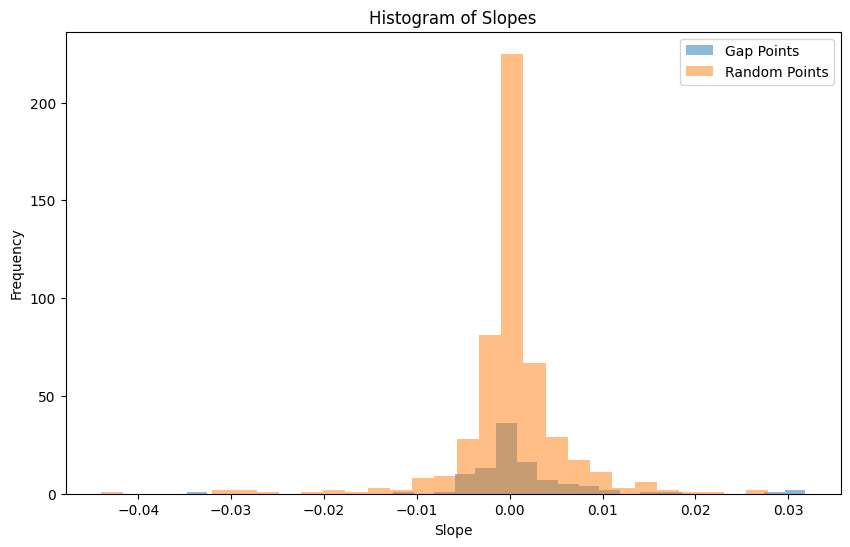

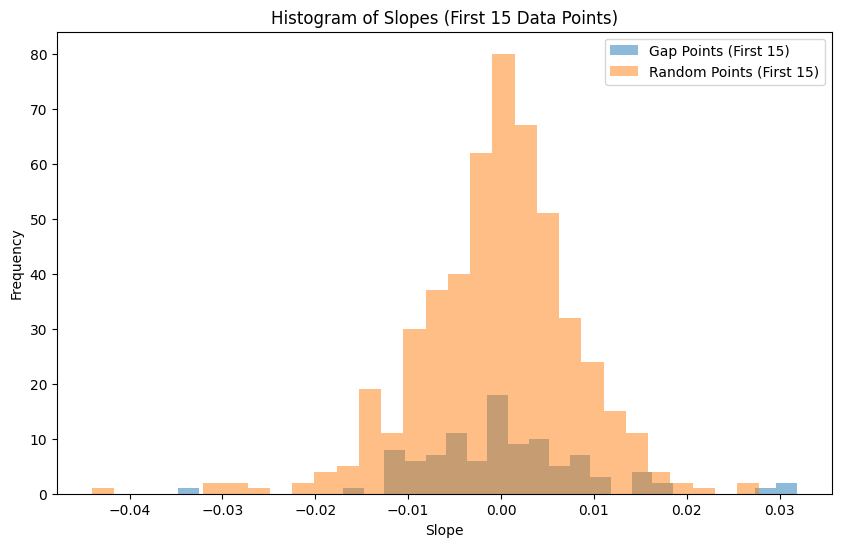

Slopes for all data points (Gap):
      Gap         Slope
83  gap79 -3.477506e-02
34  gap34  3.184848e-02
42  gap41  2.981229e-02
65  gap62  2.955788e-02
10  gap11  1.659535e-02
..    ...           ...
0    gap1 -9.411025e-05
96  gap95  7.417549e-05
39  gap39  5.319767e-05
72  gap69  2.511403e-05
62   gap6  5.154122e-07

[101 rows x 2 columns]
Average slope for all data points (Gap): 0.00123085780750155
Slopes for all data points (Random):
            Random         Slope
419  gap79_random5 -4.402943e-02
415  gap79_random1 -3.074538e-02
317  gap60_random3 -3.032404e-02
214  gap41_random5 -2.958099e-02
418  gap79_random4 -2.785182e-02
..             ...           ...
3     gap1_random4  1.992743e-05
59   gap12_random5 -1.069497e-05
97    gap2_random3 -1.055924e-05
331  gap63_random2 -8.971101e-06
234  gap45_random5  2.507822e-07

[505 rows x 2 columns]
Average slope for all data points (Random): 0.0001544435928333824
Slopes for first 15 data points (Gap):
       Gap     Slope
83   gap79

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt

# Example DataFrame structures
# series_dataframe = pd.DataFrame(...) # Placeholder for your actual dataframe
# series_dataframe_random = pd.DataFrame(...) # Placeholder for your actual dataframe

# Function to calculate slope of time series
def calculate_slopes(df):
    slopes = {}
    for column in df.columns:
        series = df[column].dropna()
        if len(series) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(series.index.map(pd.Timestamp.toordinal), series.values)
            slopes[column] = slope
    return slopes

# Calculate slopes for all data points
slopes_gap = calculate_slopes(series_dataframe)
slopes_random = calculate_slopes(series_dataframe_random)

# Plot histogram of the slopes
plt.figure(figsize=(10, 6))
plt.hist(list(slopes_gap.values()), bins=30, alpha=0.5, label='Gap Points')
plt.hist(list(slopes_random.values()), bins=30, alpha=0.5, label='Random Points')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Slopes')
plt.legend()
plt.show()

# Function to calculate slope of the first 15 data points
def calculate_slopes_first_15(df):
    slopes = {}
    for column in df.columns:
        series = df[column].dropna()[:15]
        if len(series) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(series.index.map(pd.Timestamp.toordinal), series.values)
            slopes[column] = slope
    return slopes

# Calculate slopes for the first 15 data points
slopes_gap_first_15 = calculate_slopes_first_15(series_dataframe)
slopes_random_first_15 = calculate_slopes_first_15(series_dataframe_random)

# Plot histogram of the slopes for the first 15 data points
plt.figure(figsize=(10, 6))
plt.hist(list(slopes_gap_first_15.values()), bins=30, alpha=0.5, label='Gap Points (First 15)')
plt.hist(list(slopes_random_first_15.values()), bins=30, alpha=0.5, label='Random Points (First 15)')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.title('Histogram of Slopes (First 15 Data Points)')
plt.legend()
plt.show()

# Store slopes in dataframes for output
slopes_gap_df = pd.DataFrame(list(slopes_gap.items()), columns=['Gap', 'Slope'])
slopes_random_df = pd.DataFrame(list(slopes_random.items()), columns=['Random', 'Slope'])
slopes_gap_first_15_df = pd.DataFrame(list(slopes_gap_first_15.items()), columns=['Gap', 'Slope'])
slopes_random_first_15_df = pd.DataFrame(list(slopes_random_first_15.items()), columns=['Random', 'Slope'])

# Sort DataFrames by the magnitude of the slopes
slopes_gap_df['Abs_Slope'] = slopes_gap_df['Slope'].abs()
slopes_gap_df = slopes_gap_df.sort_values(by='Abs_Slope', ascending=False).drop(columns='Abs_Slope')

slopes_random_df['Abs_Slope'] = slopes_random_df['Slope'].abs()
slopes_random_df = slopes_random_df.sort_values(by='Abs_Slope', ascending=False).drop(columns='Abs_Slope')

slopes_gap_first_15_df['Abs_Slope'] = slopes_gap_first_15_df['Slope'].abs()
slopes_gap_first_15_df = slopes_gap_first_15_df.sort_values(by='Abs_Slope', ascending=False).drop(columns='Abs_Slope')

slopes_random_first_15_df['Abs_Slope'] = slopes_random_first_15_df['Slope'].abs()
slopes_random_first_15_df = slopes_random_first_15_df.sort_values(by='Abs_Slope', ascending=False).drop(columns='Abs_Slope')

# Calculate average slopes
avg_slope_gap = np.mean(list(slopes_gap.values()))
avg_slope_random = np.mean(list(slopes_random.values()))
avg_slope_gap_first_15 = np.mean(list(slopes_gap_first_15.values()))
avg_slope_random_first_15 = np.mean(list(slopes_random_first_15.values()))

# Display DataFrames and average slopes
print("Slopes for all data points (Gap):")
print(slopes_gap_df)
print(f"Average slope for all data points (Gap): {avg_slope_gap}")

print("Slopes for all data points (Random):")
print(slopes_random_df)
print(f"Average slope for all data points (Random): {avg_slope_random}")

print("Slopes for first 15 data points (Gap):")
print(slopes_gap_first_15_df)
print(f"Average slope for first 15 data points (Gap): {avg_slope_gap_first_15}")

print("Slopes for first 15 data points (Random):")
print(slopes_random_first_15_df)
print(f"Average slope for first 15 data points (Random): {avg_slope_random_first_15}")


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate the average time series
def calculate_average_time_series(df):
    return df.mean(axis=1)

# Calculate the average time series for each dataframe
average_time_series_gap = calculate_average_time_series(series_dataframe_first_20)
average_time_series_random = calculate_average_time_series(series_dataframe_random_first_20)

# Calculate the mean and variance of the average time series
mean_average_time_series_gap = average_time_series_gap.mean()
variance_average_time_series_gap = average_time_series_gap.var()
mean_average_time_series_random = average_time_series_random.mean()
variance_average_time_series_random = average_time_series_random.var()

# Function to calculate mean and variance of each column
def calculate_mean_variance(df):
    mean_var = {'Mean': [], 'Variance': []}
    for column in df.columns:
        series = df[column].dropna()
        if len(series) > 0:
            mean_var['Mean'].append(series.mean())
            mean_var['Variance'].append(series.var())
        else:
            mean_var['Mean'].append(np.nan)
            mean_var['Variance'].append(np.nan)
    return pd.DataFrame(mean_var, index=df.columns)

# Calculate mean and variance for each column
mean_var_gap = calculate_mean_variance(series_dataframe_first_20)
mean_var_random = calculate_mean_variance(series_dataframe_random_first_20)

# Calculate the mean of the means and the mean of the variances
mean_mean_gap = mean_var_gap['Mean'].mean()
mean_variance_gap = mean_var_gap['Variance'].mean()
mean_mean_random = mean_var_random['Mean'].mean()
mean_variance_random = mean_var_random['Variance'].mean()


# Plot the results
plt.figure(figsize=(10, 6))

# Highlight the mean and variance of the average time series
plt.scatter([mean_average_time_series_gap], [variance_average_time_series_gap], color='red', marker='D', s=100, label='Average Time Series (Gap Points)')
plt.scatter([mean_average_time_series_random], [variance_average_time_series_random], color='blue', marker='D', s=100, label='Average Time Series (Random Points)')

# Plot the mean of means and mean of variances
plt.scatter([mean_mean_gap], [mean_variance_gap], color='red', marker='x', s=100, label='Mean of Means and Variances (Gap Points)')
plt.scatter([mean_mean_random], [mean_variance_random], color='blue', marker='x', s=100, label='Mean of Means and Variances (Random Points)')

plt.xlabel('Mean')
plt.ylabel('Variance')
plt.title('Scatter Plot of Mean vs Variance')
plt.legend()
plt.show()


NameError: name 'series_dataframe_first_20' is not defined

In [92]:
series_df=df_series_2yr_gaps_filtered
series_random_df=df_series_2yr_random1_filtered

Accuracy: 0.46511627906976744
              precision    recall  f1-score   support

           0       0.42      0.58      0.49        19
           1       0.53      0.38      0.44        24

    accuracy                           0.47        43
   macro avg       0.48      0.48      0.46        43
weighted avg       0.48      0.47      0.46        43



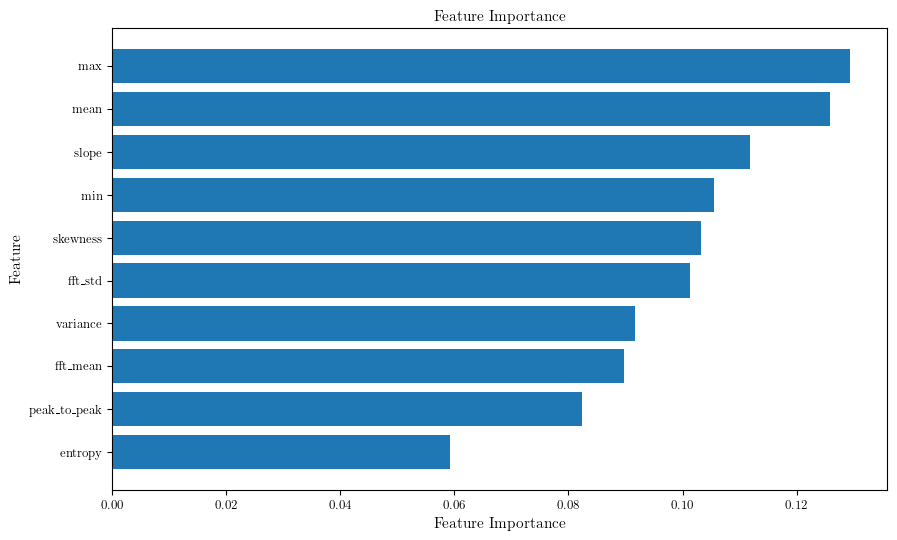

In [75]:
def hurst_exponent(ts):
    return nolds.hurst_rs(ts)

def lyapunov_exponent(ts):
    return nolds.lyap_r(ts, emb_dim=6)

def extract_advanced_features(df):
    features = []
    for column in df.columns:
        if df[column].dropna().empty:
            continue
        series = df[column].dropna()
        feature_dict = {
            'mean': series.mean(),
            'variance': series.var(),
            'max': series.max(),
            'min': series.min(),
            'skewness': skew(series),
            #'kurtosis': kurtosis(series),
            #'autocorrelation': series.autocorr(),
            'slope': np.polyfit(range(len(series)), series, 1)[0],
            'peak_to_peak': series.max() - series.min(),
            'peak_to_peak': series.max() - series.min(),
            'slope': np.polyfit(range(len(series)), series, 1)[0],
            'entropy': scipy_entropy(series.value_counts(normalize=True))
            #'zero_crossing_rate': ((series[:-1] * series[1:]) < 0).sum()
        }
        # Fourier transform features
        fft = np.fft.fft(series)
        fft = np.abs(fft[:len(fft) // 2])  # Take half as it's symmetric
        feature_dict['fft_mean'] = np.mean(fft)
        feature_dict['fft_std'] = np.std(fft)
        
        features.append(feature_dict)
    return pd.DataFrame(features)

# Extract advanced features from both dataframes
gap_features_advanced = extract_advanced_features(series_df)
random_features_advanced = extract_advanced_features(series_random_df)

# Add labels
gap_features_advanced['label'] = 1
random_features_advanced['label'] = 0

# Combine the features into a single dataframe
combined_features_advanced = pd.concat([gap_features_advanced, random_features_advanced], ignore_index=True)

# Separate features and labels
X_advanced = combined_features_advanced.drop('label', axis=1)
y_advanced = combined_features_advanced['label']

# Ensure there are no NaNs in the dataset, without imputing
# Drop columns where all values are NaN
X_advanced = X_advanced.dropna(axis=1, how='all')

# Split the data into training and testing sets
X_train_advanced, X_test_advanced, y_train_advanced, y_test_advanced = train_test_split(X_advanced, y_advanced, test_size=0.2, random_state=40)

# Train the Random Forest classifier
clf_advanced = RandomForestClassifier(n_estimators=200, random_state=40)
clf_advanced.fit(X_train_advanced, y_train_advanced)

# Make predictions
y_pred_advanced = clf_advanced.predict(X_test_advanced)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test_advanced, y_pred_advanced))
print(classification_report(y_test_advanced, y_pred_advanced))

# Plot feature importances
import matplotlib.pyplot as plt

feature_importances_advanced = clf_advanced.feature_importances_

features_df_advanced = pd.DataFrame({
    'Feature': X_advanced.columns,
    'Importance': feature_importances_advanced
})

features_df_advanced = features_df_advanced.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(features_df_advanced['Feature'][:20], features_df_advanced['Importance'][:20])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [143]:
df_series_2yr_gaps_filtered.drop(['label'],axis=1,inplace=True)

In [144]:
df_series_2yr_random1_filtered.drop(['label'],axis=1,inplace=True)

In [164]:
series_df=df_series_2yr_gaps_filtered
series_random_df=df_series_2yr_random1_filtered

In [165]:
series_df

,gap1,gap10,gap100,gap101,gap102,gap103,gap104,gap105,gap106,gap107,...,gap90,gap91,gap92,gap93,gap94,gap95,gap96,gap97,gap98,gap99
2017-11-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-13 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-23 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
s1=series_df.T
s2=series_random_df.T

In [153]:
s2['label']=0
s1['label']=1

In [170]:
type(d1)

method

In [172]:
s1=series_df.copy().T
s2=series_random_df.copy().T

s1['label']=1
s2['label']=0

comb1=pd.concat([s1, s2], axis=0)

X=comb1.iloc[:,:-1]
y=comb1.iloc[:,-1]

X=X.interpolate(method='linear', axis=1).fillna(method='bfill', axis=1).fillna(method='ffill', axis=1)

Epoch 1/20


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5209 - loss: 0.6970 - val_accuracy: 0.6571 - val_loss: 0.6809
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4419 - loss: 0.6942 - val_accuracy: 0.6000 - val_loss: 0.6876
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4722 - loss: 0.6978 - val_accuracy: 0.4571 - val_loss: 0.6954
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4975 - loss: 0.6936 - val_accuracy: 0.4000 - val_loss: 0.6983
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5620 - loss: 0.6889 - val_accuracy: 0.5429 - val_loss: 0.6912
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4192 - loss: 0.7002 - val_accuracy: 0.6286 - val_loss: 0.6817
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5111 - loss: 0.6911 - val_accuracy: 0.6571 - val_loss: 0.6736
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5113 - loss: 0.6912 - val_accuracy: 0.6286 - val_loss: 0.6726
Epoch 9/20
5/5 ━━━━━━━━━━━

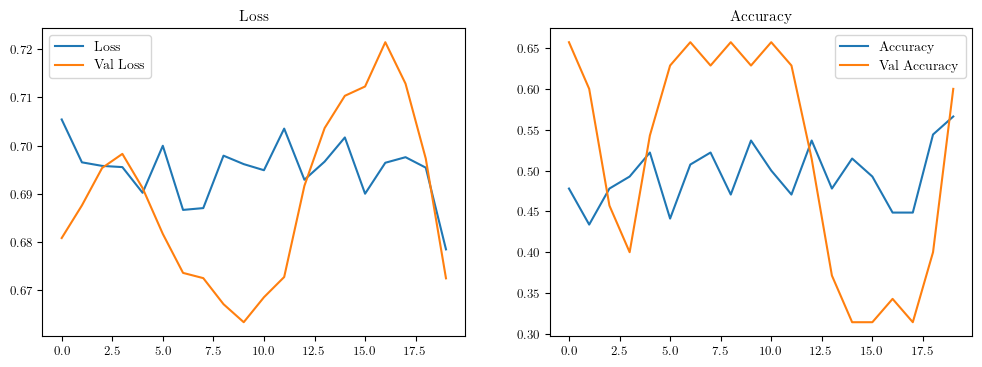

In [175]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, recall_score

# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Reshape X to fit LSTM input requirements: (samples, time steps, features)
X_reshaped = X_normalized.reshape((X_normalized.shape[0], X_normalized.shape[1], 1))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calculate recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

# Print detailed classification report
report = classification_report(y_test, y_pred, target_names=["Non-gap", "Gap"])
print(report)

# Optional: Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()


In [176]:
from sklearn.metrics import recall_score

# Assuming y_test is your true labels and y_pred is your predicted labels
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")


Recall: 0.7500


In [86]:
unique, counts = np.unique(y_test ,return_counts=True)

In [88]:
counts

array([482, 497], dtype=int64)